# Central African Republic Machine learning on Conflict Fatalities

This notebook intends to perform a use case of machine learning models and conflicts explainability on one of the six countries (Central African Republic). This approach is due to the computational capacity required to train the models.

For our target variable, the group decided to carry on with a regressor that tries to predict the fatalities, both from the state and non-state violence standpoint (we summed up all the fatality variables which were included in the original Afrogrid dataset). Precisely, what we do is the following:

<div class="alert alert-block alert-success">
  <ol>
    <li><b>Modules + Target Variable:</b> We import the modules needed and clean first the variables which should be excluded outright, while creating our target variable.</li>
    <li><b>EDA:</b> We perform a simple exploratory data analysis to look for multicollinearity and strange distributions. In this same place, we will create, in line with the litearture, a lagged conflict variable, which is deemed as one of the best predictors that can be introduced in a model of this kind.</li>
    <li><b>Multicollinearity + Feature Importance:</b> We carry on a first linear regression model in order to evaluate feature importance, and pair up those importances with the multicollinear variables to craft a restrictive approach that prioritizes conservativeness to data elimination if feature importances are high.</li>
    <li><b>Random Forest Regression:</b> We carry on a Random Forest Regression hyperparameterized with GridSearchCV, and extract the feature importance while evaluating overfitting.</li>
    <li><b>Gradient Boosted Tree Regression:</b> We carry on a Gradient Boosted Tree Regression, both for the dataset as a whole as well as for each month; and evaluate for each the feature importance and overfitting.</li>
    <li><b>Keras Sequential Neural Network:</b> We carry on a Keras Sequential Neural Network regressor, and evaluate feature importance and overfitting.</li>     
  </ol>
</div>


At the end, a plot showcases the R-squared metrics and Mean Squared Error for all models. 

## Modules and Target Variable

In [1]:
#We download all the needed packages

!pip install tensorflow
!pip install keras

# We import all modules that may be needed ahead.

import pandas as pd
import numpy as np
from itertools import product

#Scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

#Plotting libraries
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

# And a warning hider to make our code cleaner.
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

!pip install geopandas

In [27]:
df=pd.read_csv("countries/Central African Republic.csv")
df

,gid,year,month,ym,ged_state,ged_nonstate,ged_viol_tot,ged_viol_state,ged_viol_nonstate,ged_state_fatal_best,...,diamprim_s,goldplacer_s,goldsurface_s,mountains_mean,ttime_mean,year_y,droughtstart_speibase,goldvein_y,nearest_country_dist,own_borders_dist
0,132873,2004,1,2004-01-01,0,0,0,0,0,0,...,NaN,NaN,NaN,0.026944,2615.0090,2012,-0.727961,NaN,2.944462,2.944462
1,132873,2004,1,2004-01-01,0,0,0,0,0,0,...,NaN,NaN,NaN,0.026944,2615.0090,2014,NaN,NaN,2.944462,2.944462
2,132873,2004,1,2004-01-01,0,0,0,0,0,0,...,NaN,NaN,NaN,0.026944,2615.0090,2009,-0.180646,NaN,2.944462,2.944462
3,132873,2004,1,2004-01-01,0,0,0,0,0,0,...,NaN,NaN,NaN,0.026944,2615.0090,2011,0.155594,NaN,2.944462,2.944462
4,132873,2004,1,2004-01-01,0,0,0,0,0,0,...,NaN,NaN,NaN,0.026944,2615.0090,2013,-0.807950,NaN,2.944462,2.944462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297655,145126,2014,12,2014-12-01,0,0,0,0,0,0,...,NaN,NaN,1.0,0.000000,958.5269,2007,-1.577061,NaN,20.816730,20.816730
297656,145126,2014,12,2014-12-01,0,0,0,0,0,0,...,NaN,NaN,1.0,0.000000,958.5269,2005,-1.038909,NaN,20.816730,20.816730
297657,145126,2014,12,2014-12-01,0,0,0,0,0,0,...,NaN,NaN,1.0,0.000000,958.5269,2008,-1.762356,NaN,20.816730,20.816730
297658,145126,2014,12,2014-12-01,0,0,0,0,0,0,...,NaN,NaN,1.0,0.000000,958.5269,2004,-1.058612,NaN,20.816730,20.816730


It is important to note the team decided to get rid of all columns with more than 30% of missing values. This was considered as they were few in the previous general dataset analyses, and filling them in would cause a lot of noise. This way, we protect lots of instances with huge value for us, which gain even more importance when we take into account that if we predict in our target feature fatalities, fatality variables must be removed to avoid target leakage.

In [28]:
#We now remove variables whose variance may not be representative or that may cause target leakage.
df.drop(["ged_state_fatal_high", "ged_state_fatal_low", "ged_state_fatal_sidea", "ged_state_fatal_sideb",
         "ged_nonstate_fatal_high", "ged_nonstate_fatal_low", "ged_nonstate_fatal_sidea",
         "ged_nonstate_fatal_sideb", "ged_viol_fatal_tot_high", "ged_viol_fatal_tot_low",
         "ged_viol_fatal_state_best", "ged_viol_fatal_state_high", "ged_viol_fatal_state_low", 
         "ged_viol_fatal_nonstate_best",
          "ged_viol_fatal_nonstate_high", "ged_viol_fatal_nonstate_low", "acled_battle_state", 
         "acled_battle_rebel","acled_battle_polmil", "acled_battle_idmil", "acled_remote_state", 
         "acled_remote_rebel", "acled_remote_polmil", "acled_remote_idmil", "acled_viol_state",
         "acled_viol_rebel","acled_viol_polmil", "acled_viol_idmil", "acled_fatal_state", "acled_fatal_rebel", 
          "acled_fatal_polmil", "acled_fatal_idmil", "pitf_tot_deaths_inc", "pitf_tot_deaths_camp",
          "pitf_state_deaths_inc", "pitf_state_deaths_camp", "pitf_nonstate_sanc_deaths_inc",
          "pitf_nonstate_sanc_deaths_camp", "pitf_nonstate_deaths_inc", "pitf_nonstate_deaths_camp", 
         "pitf_multiple_deaths_inc","pitf_multiple_deaths_camp", "pitf_trans_deaths_inc", "COWCODE",
         "row", "col", "year_y", "country.name", "xcoord", "ycoord", "pitf_trans_deaths_camp", "gid"], 
        axis=1, inplace=True)

# We remove "SCAD" columns, with info from it being in other variables better suited for less NA
scad_cols = [col for col in df.columns if 'scad' in col]
df = df.drop(columns=scad_cols)

#We remove columns with more than 30% of missing values
missing_percentage = df.isna().mean() * 100
selected_columns = missing_percentage[missing_percentage <= 30].index
df= df[selected_columns].copy()

#We set now the target variable
df["target"]=df["ged_state_fatal_best"] + df["ged_nonstate_fatal_best"] + df["ged_viol_fatal_tot_best"]
df.drop(["ged_state_fatal_best", "ged_nonstate_fatal_best", "ged_viol_fatal_tot_best"], axis=1, inplace=True)

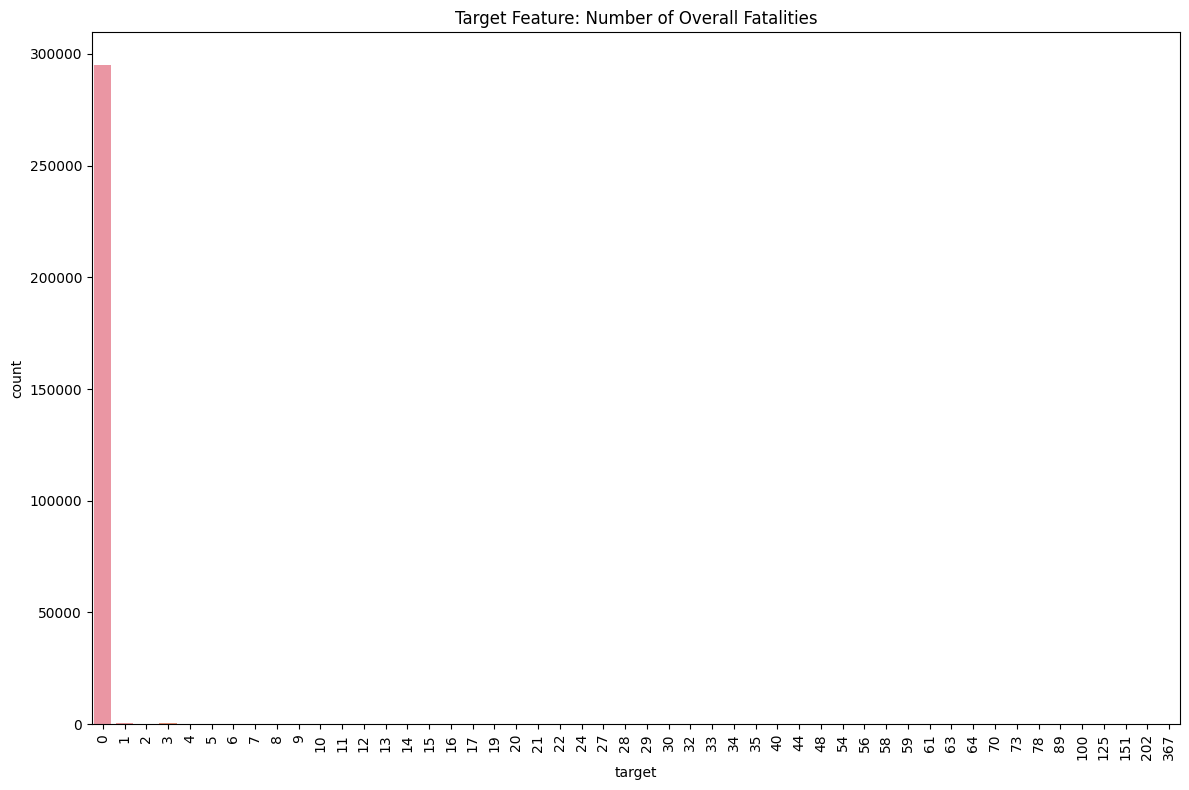

In [29]:
#Target feature distribution

plt.figure(figsize=(12, 8))  
plt.title("Target Feature: Number of Overall Fatalities")
sns.countplot(data=df, x='target')
plt.xticks(rotation=90)  
plt.tight_layout()  

plt.show()

Now, we will add lagged conflict variables, in line with the literature review carried out by the team. This specific type of variable is important across different articles, and has therefore been selected and included here as a predictor in line with it.

In [30]:
#We set up also the lagged variable, using "ym", and drop "ym" as we already have year and months columns.

df = df.sort_values('ym')
num_lags = 3
for i in range(1, num_lags+1):
    df['lag{}'.format(i)] = df['target'].shift(i)
    
df.drop("ym", axis=1, inplace=True)

## Exploratory Data Analysis (EDA): Multicollinearity Matrix and Features Distribution

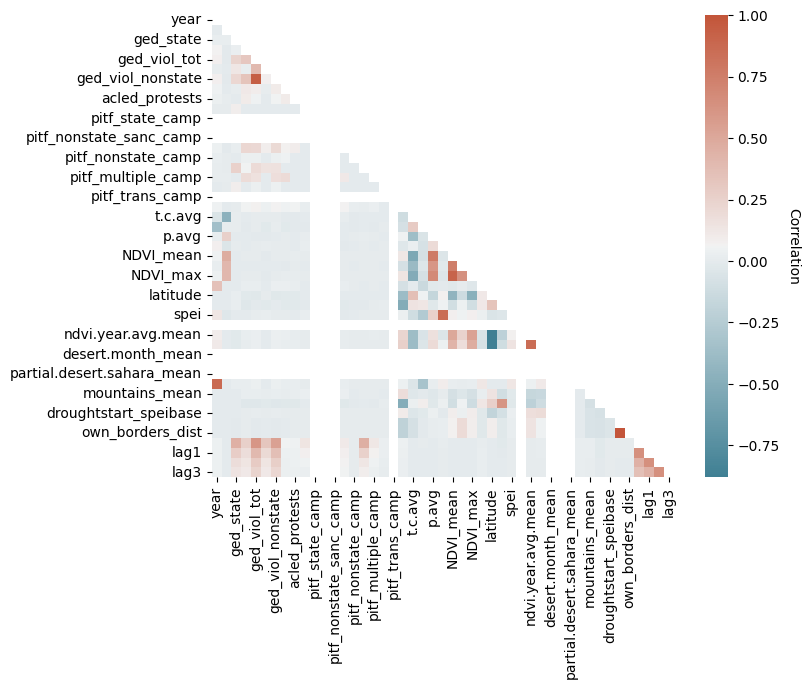

In [31]:
# Correlation matrix

# We calculate the threshold for missing values
threshold = len(df) * 0.3
df_filtered = df.dropna(thresh=threshold, axis=1)

# We fill remaining missing values with 0
df_filled = df_filtered.fillna(0)

# We one-hot encode categorical columns
df_encoded = pd.get_dummies(df_filled)

# And we create the correlation matrix
# And we create the correlation matrix
corr_matrix = df_encoded.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=False, square=True, cbar=True)
cbar = plt.gca().collections[0].colorbar
cbar.set_label('Correlation', rotation=270, labelpad=15)
plt.show()

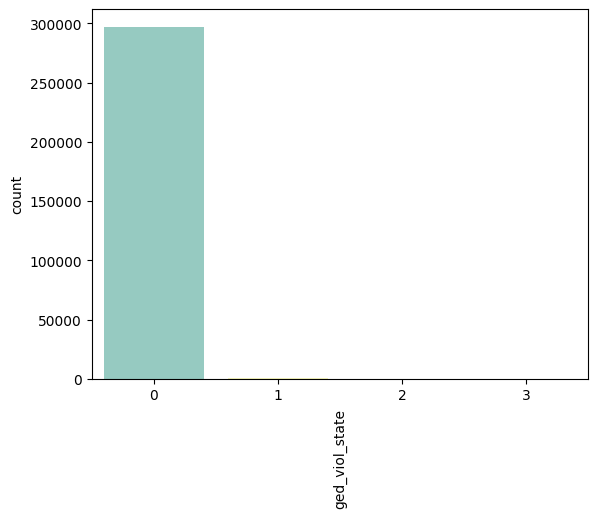

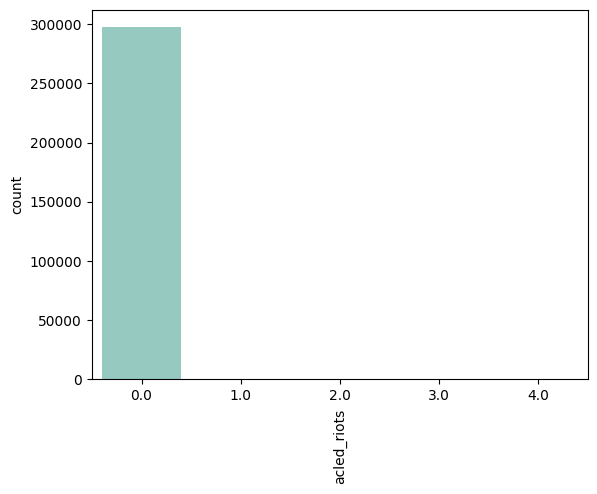

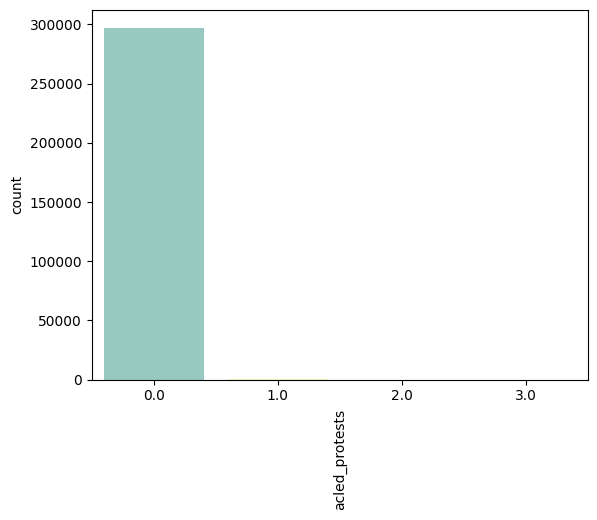

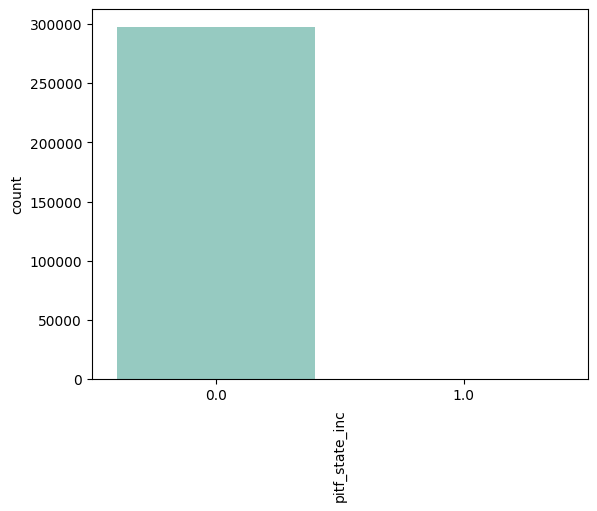

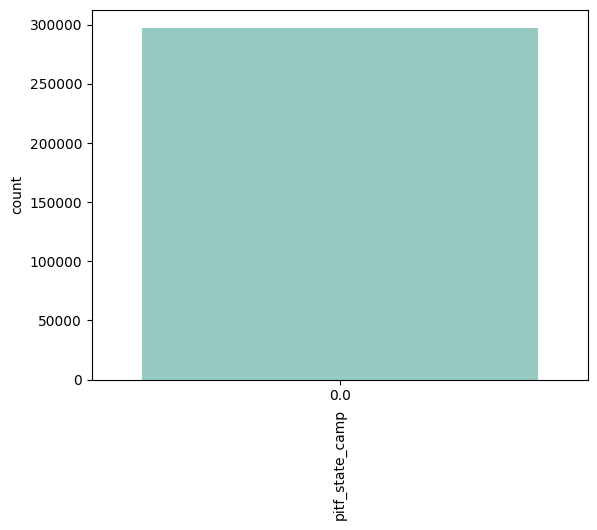

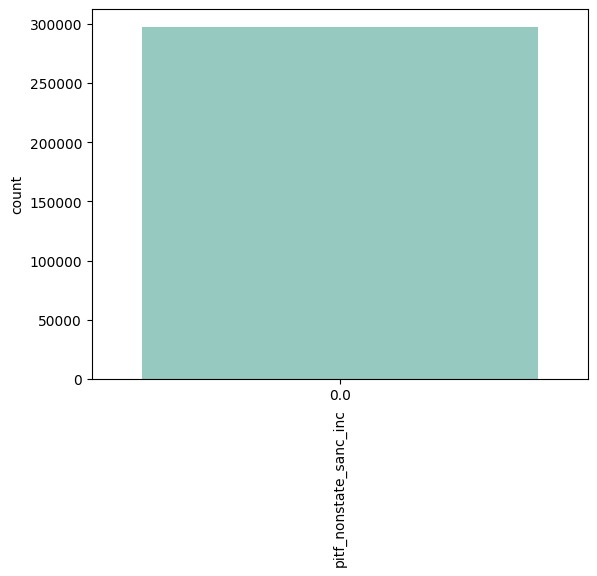

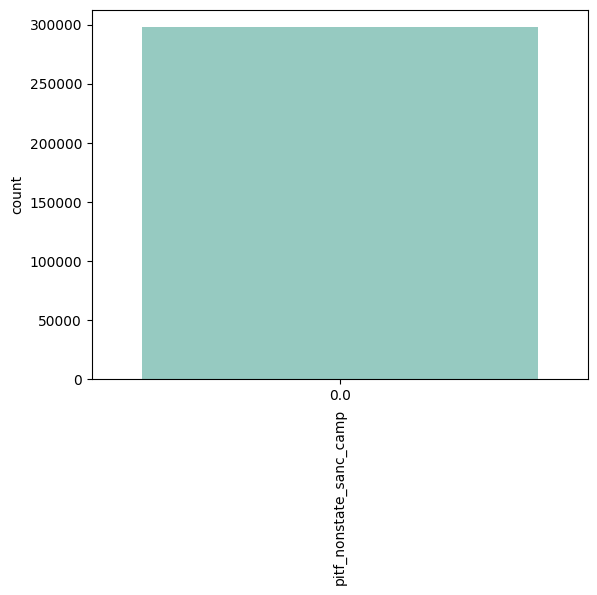

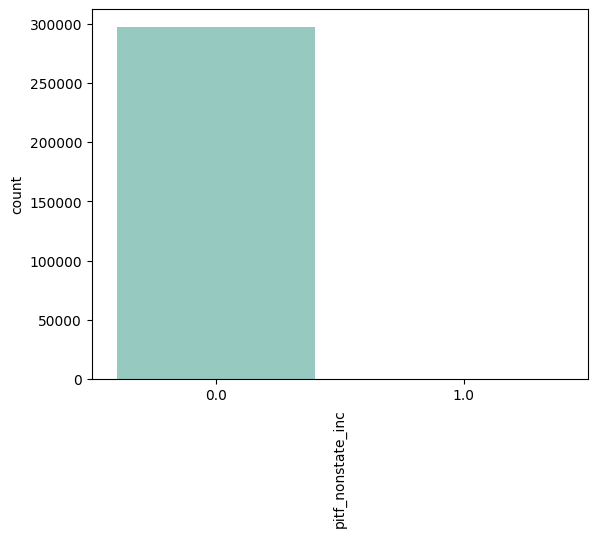

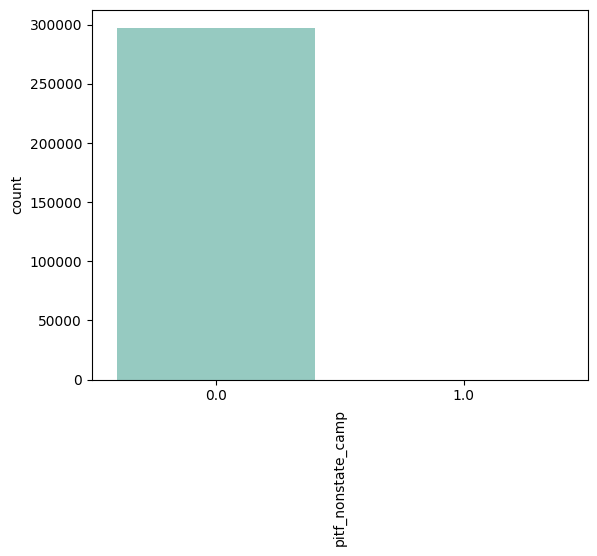

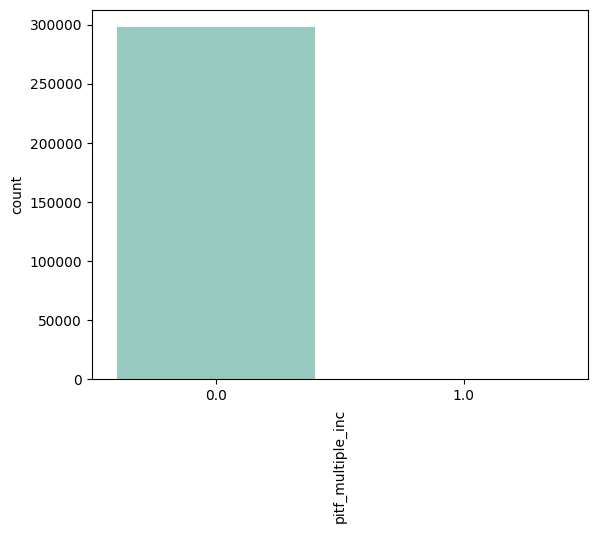

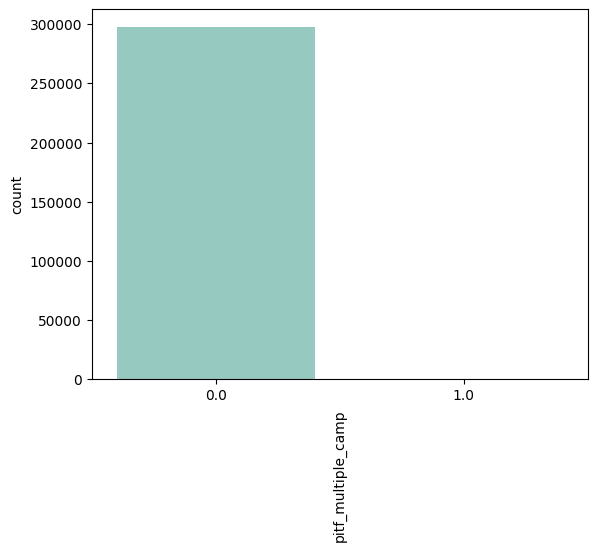

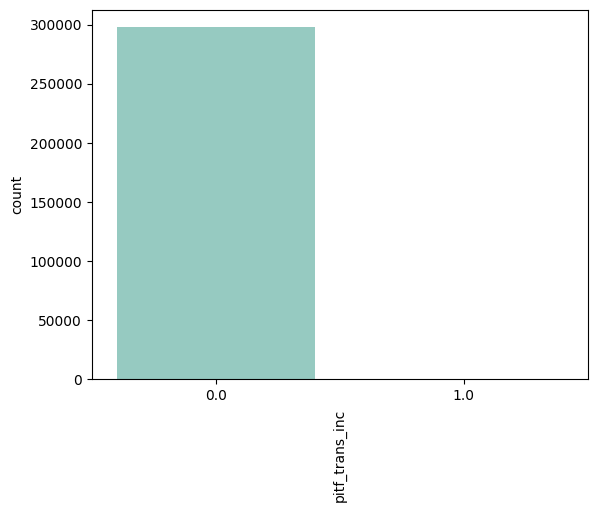

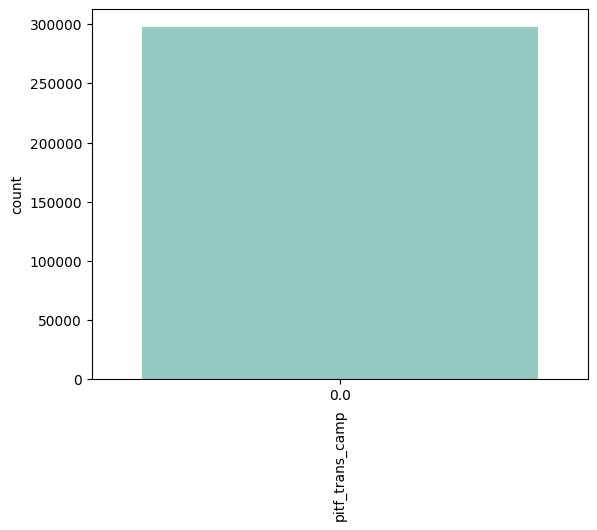

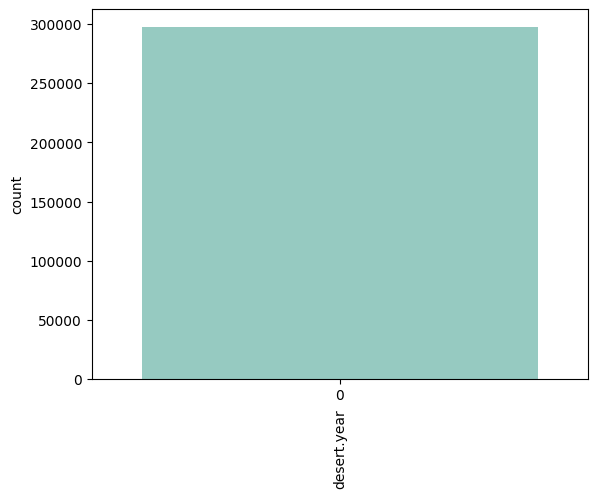

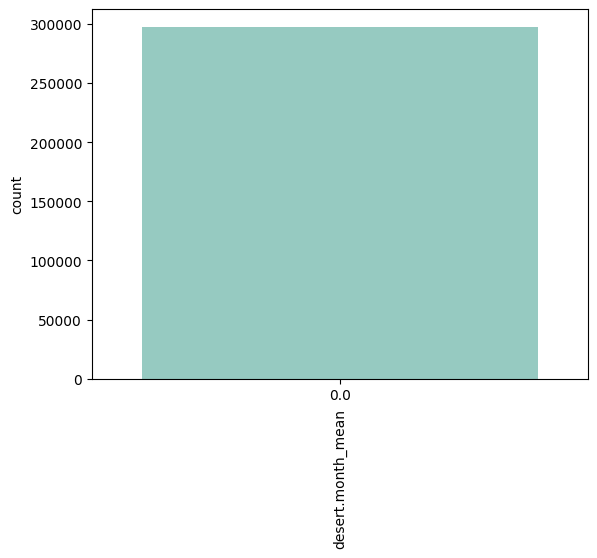

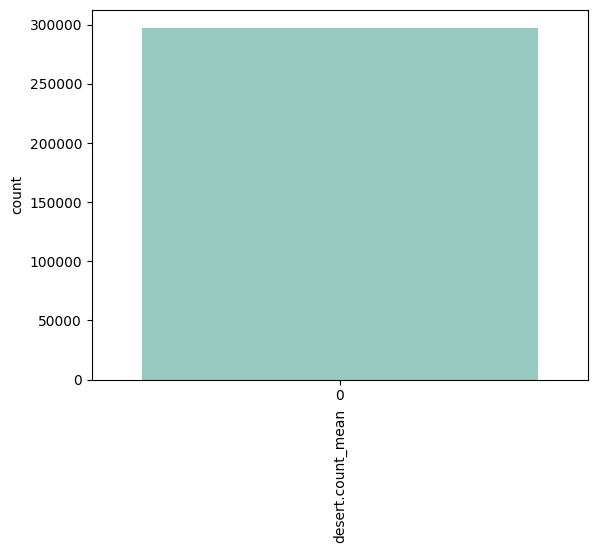

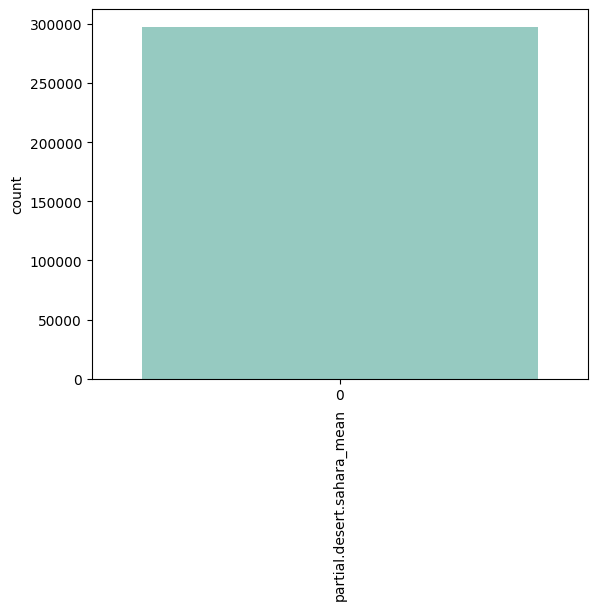

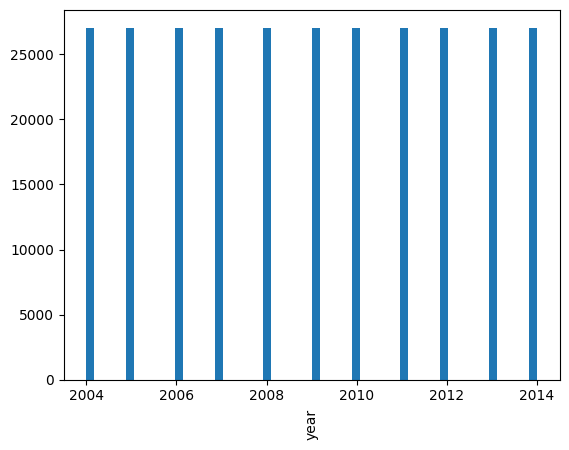

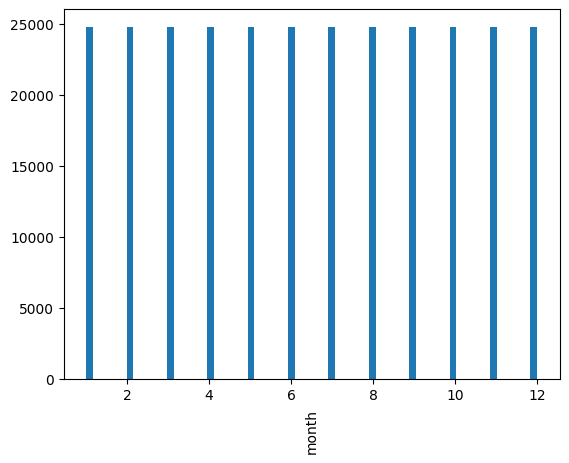

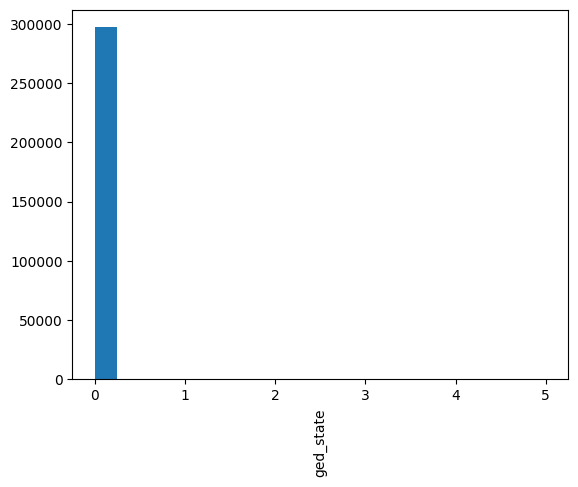

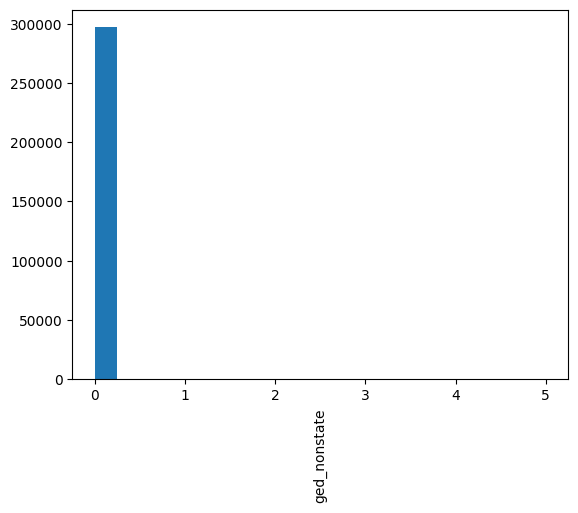

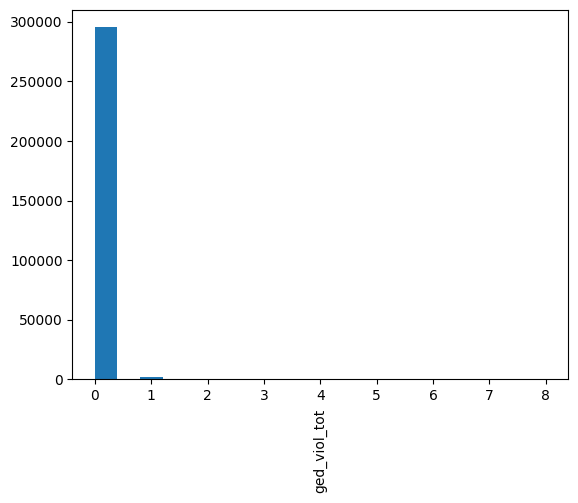

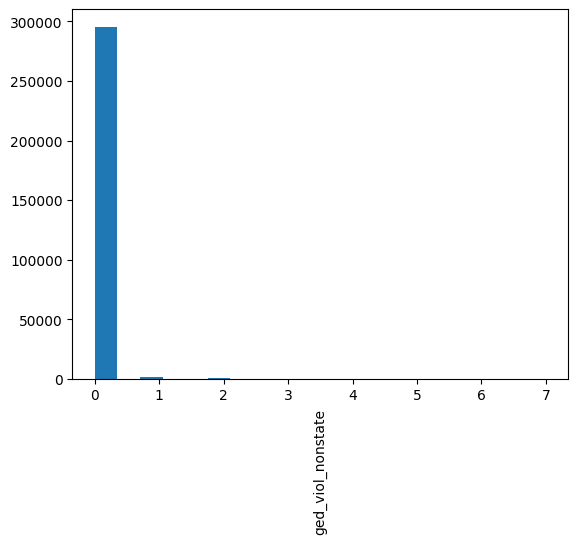

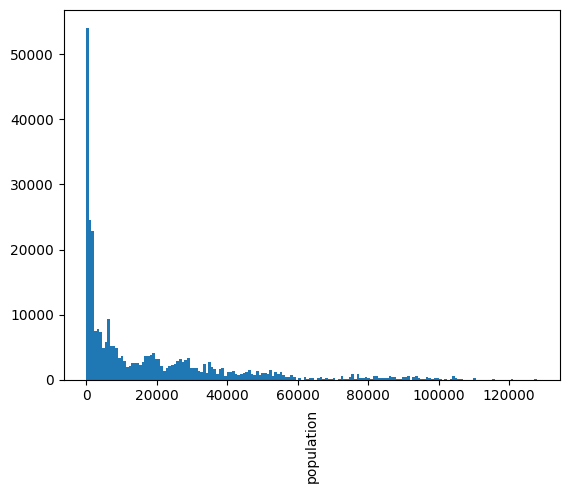

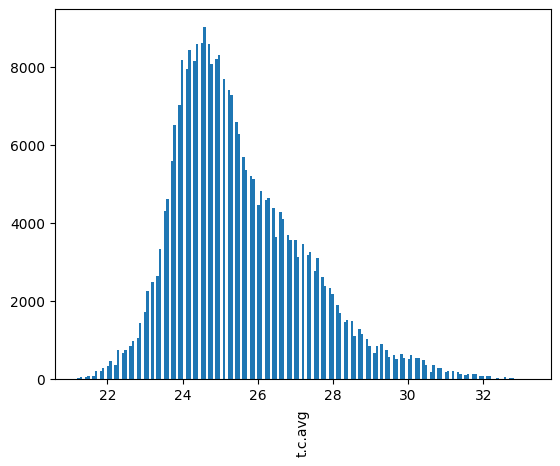

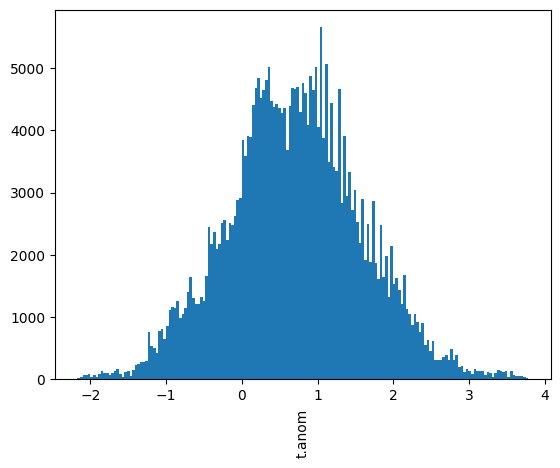

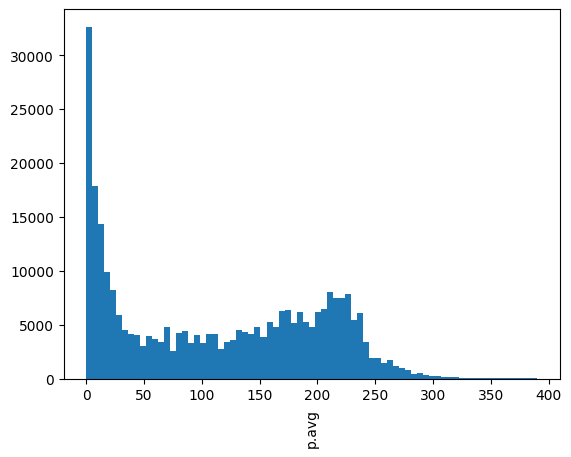

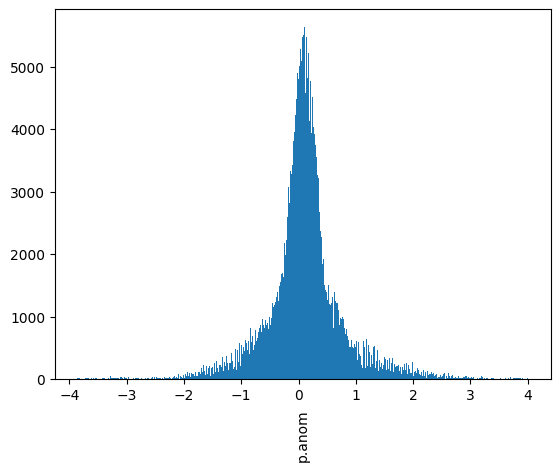

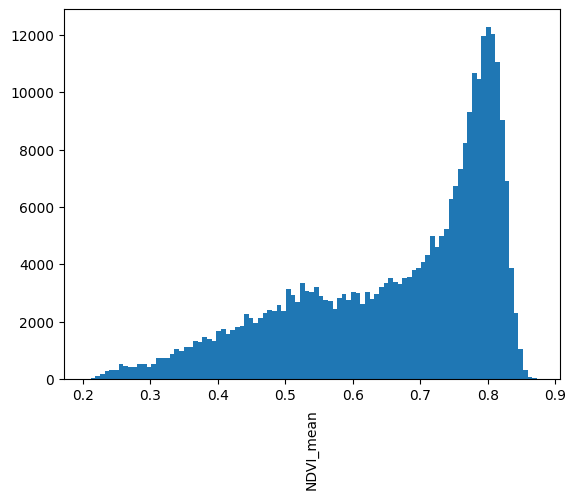

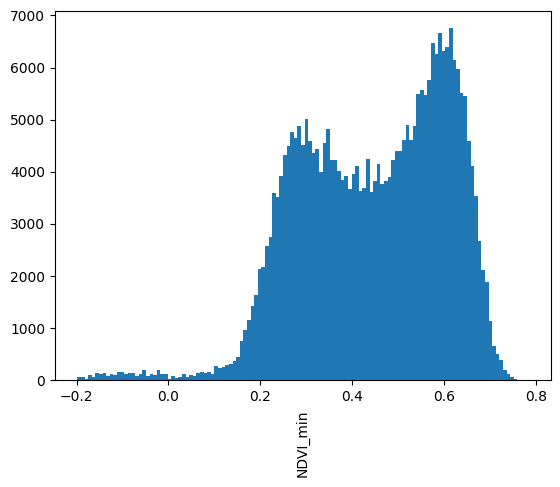

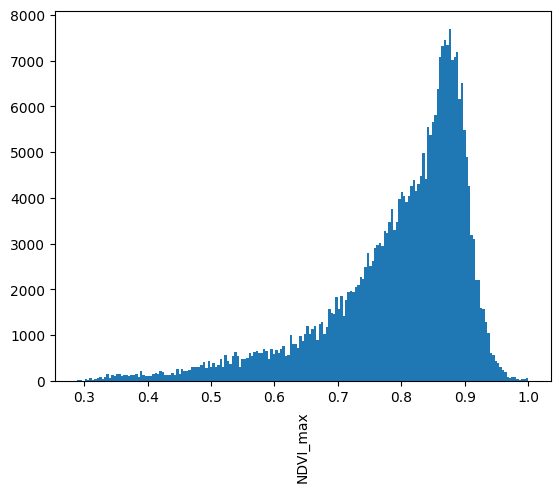

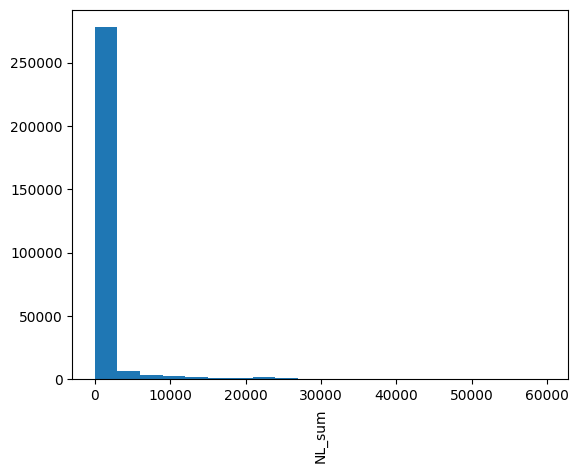

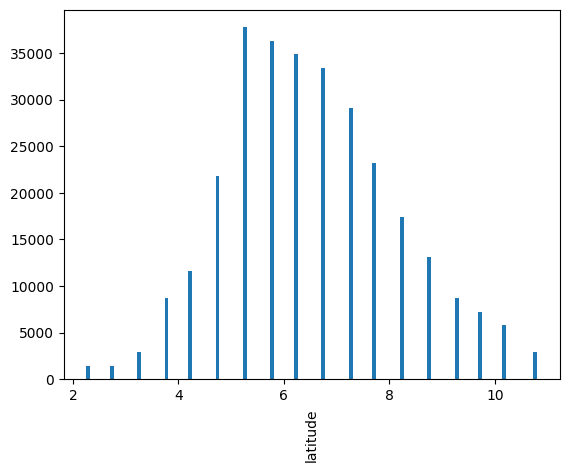

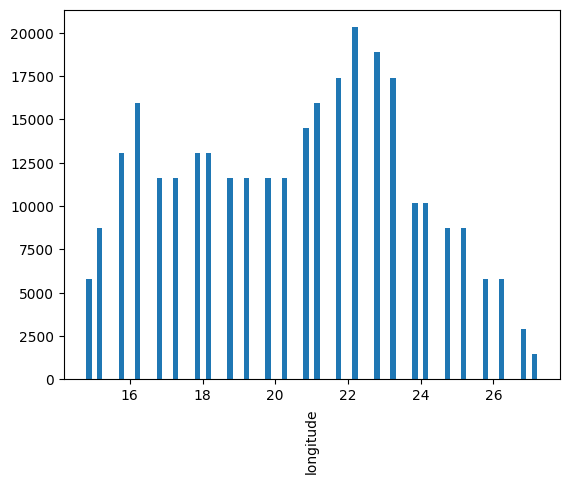

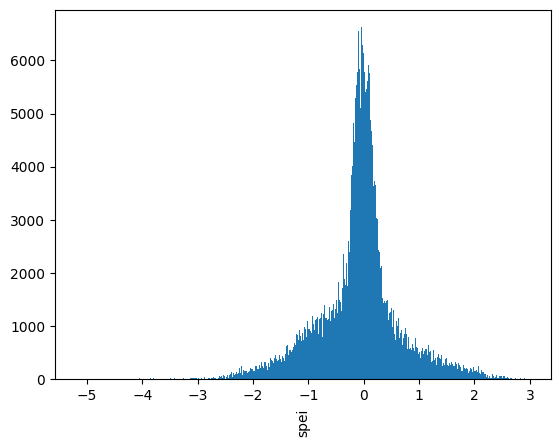

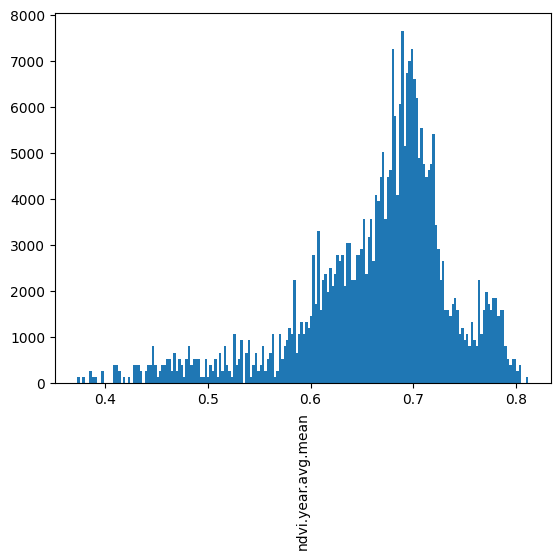

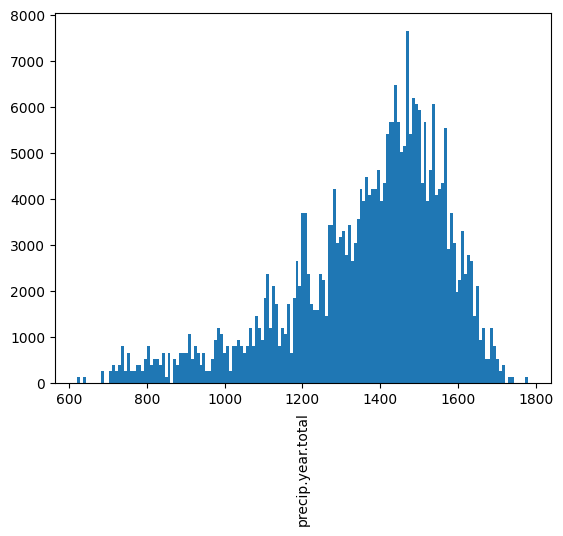

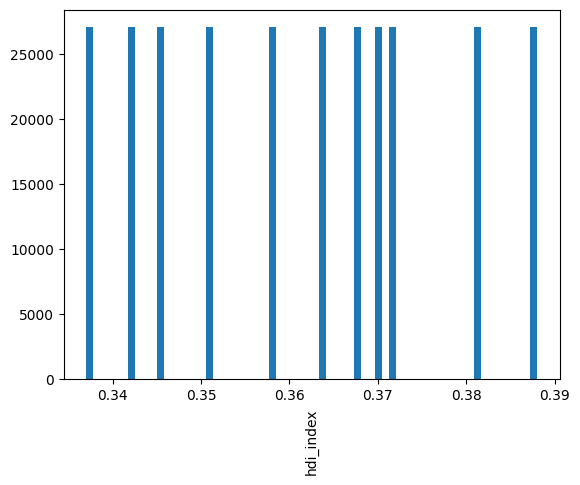

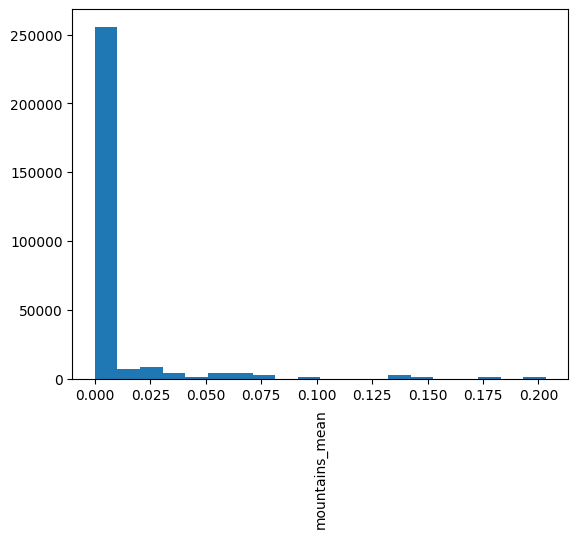

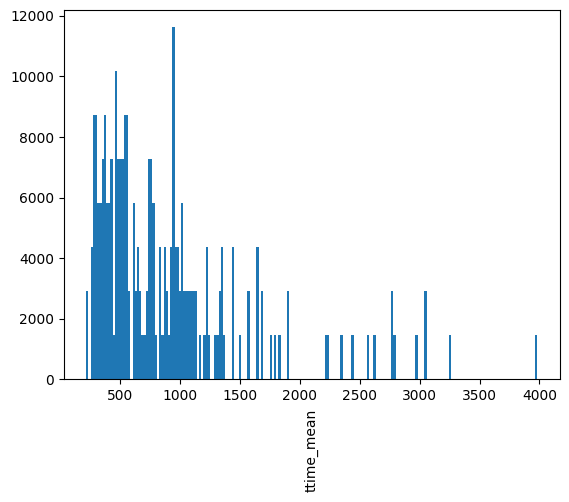

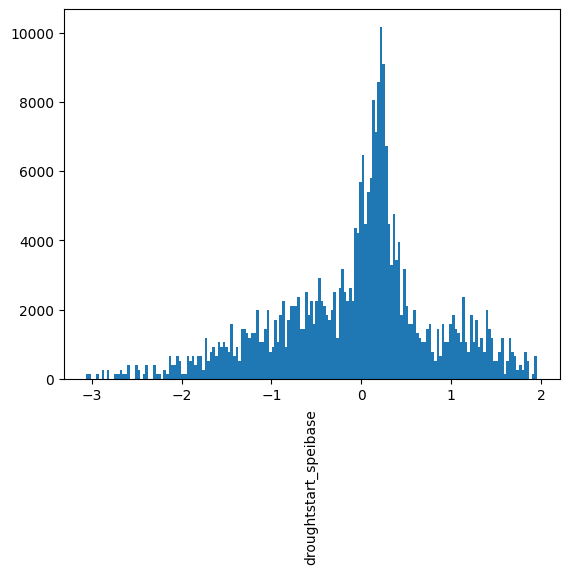

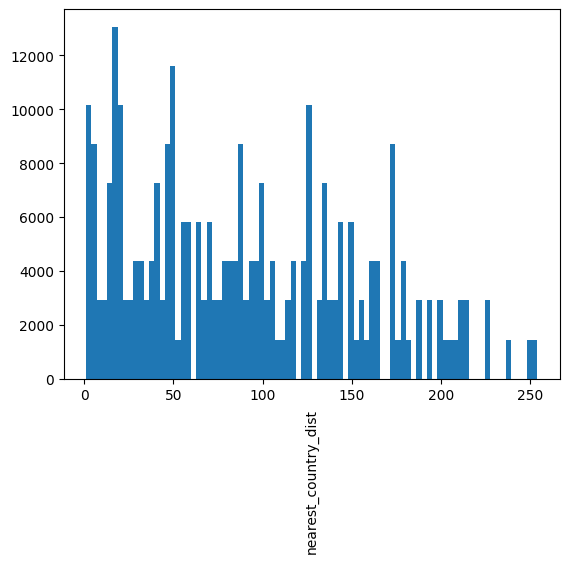

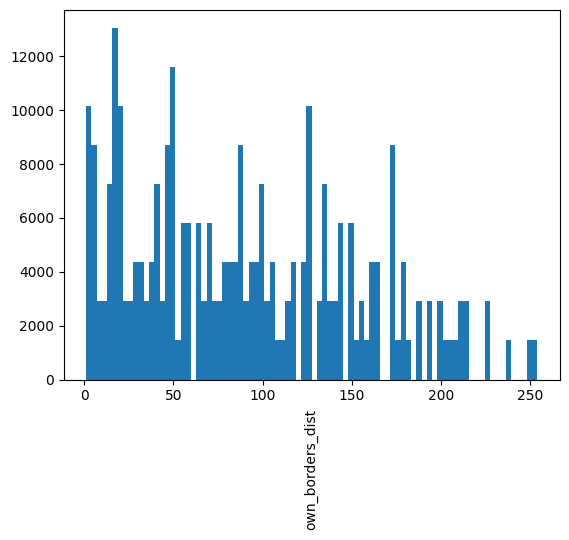

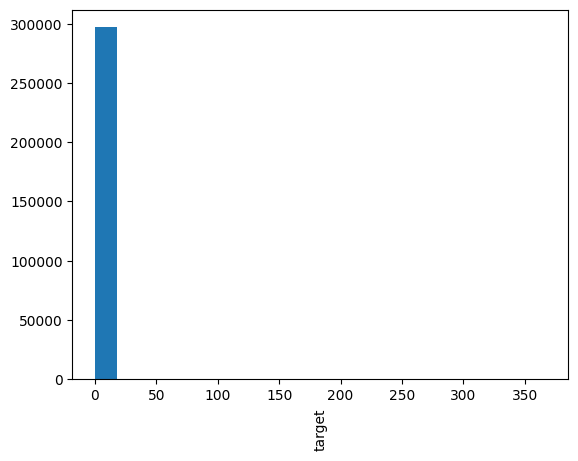

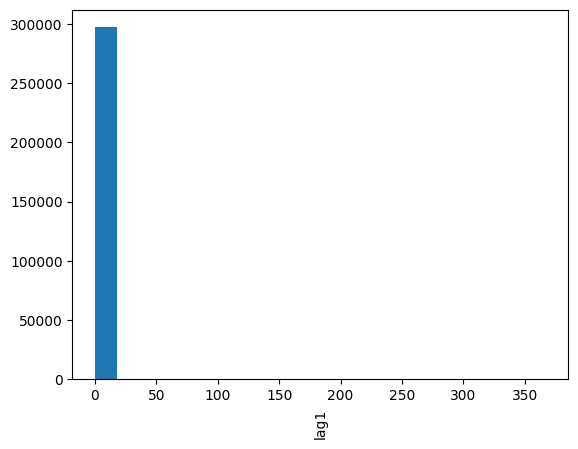

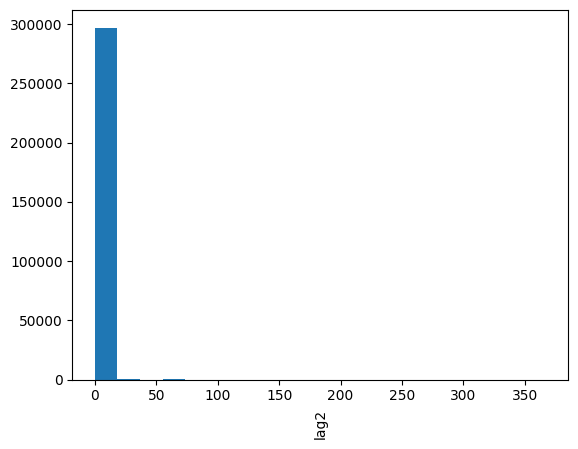

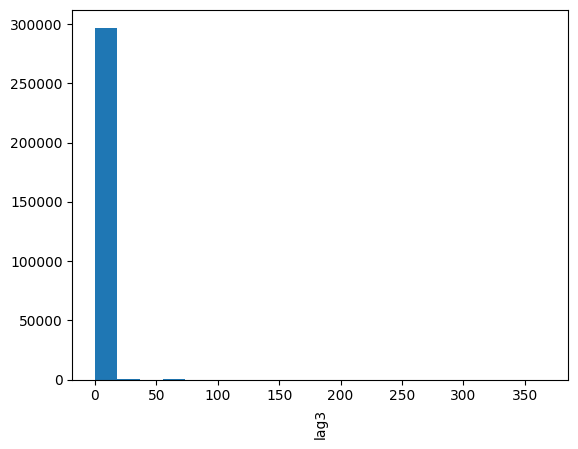

In [32]:
#Variables distribution

#We plot all variables that are discrete as countplots, and all continous variables as histograms.

# Countplots for numeric variables that are discrete
numeric_cols = df.select_dtypes(include=['float64', 'int64'])
object_cols = df.select_dtypes(include='object')

for col in numeric_cols:
    if df[col].nunique() <= 5 and len(df[col].dropna()) > 0:  
        sns.countplot(x=col, data=df, palette="Set3")
        plt.xlabel(col, rotation=90)  
        plt.show()

for col in object_cols:
    if len(df[col].dropna()) > 0:  # Check if the variable has data points
        sns.countplot(x=col, data=df, palette="Set3")
        plt.xlabel(col, rotation=90)  
        plt.show()

# Histograms for numeric columns that are continuous
numeric_cols = df.select_dtypes(include=['float64', 'int64'])
for col in numeric_cols:
    if df[col].nunique() > 5 and len(df[col].dropna()) > 0:  # Check if the variable is continuous and has data points
        plt.hist(df[col].dropna(), bins='auto')
        plt.xlabel(col, rotation=90)  # Rotate the label 90 degrees
        plt.show()

## Multicollinearity and Feature Importance (with multicollinearity 75%)

In [33]:
#We instantiate here df2 for its future usage n the correlation matrix
df2=df.copy()

We create a low fidelity model using a linear regression. We are interested in the R-squared being as high as possible, so that our feature importance analysis has an important predictive power backing. As we can observe, the lagged variable and the others perfectly do the job: R-squared is good enough and this allows us to make sense out of the feature importance. Here, we create a function called ```data_preparation```, which will help us simplify the pipeline creation process in subsequent models. In line with the literature review, imputation of remaining missing values is best done by a simple mode imputation in categorical variables and mean imputation in numerical ones.

In [34]:
#We will create a low fidelity model in order to check for the variables importance, which will assess us in 
#a better multicollinear variables elimination.


#We first split the target and the other features, and do a standard train-test-split
X=df.drop(["target"], axis=1)
y=df["target"]

X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42)

#We encode inside a function (which will be used later on) the data transformation required
def data_preparation(dataset):
    cat_imp = SimpleImputer(strategy="most_frequent")
    num_imp = SimpleImputer(strategy="median")
    onehot = OneHotEncoder(sparse=False)
    inner_steps = [("simple_imputer", cat_imp), ("onehot", onehot)]
    inner_pipe = Pipeline(inner_steps)

    categorical_cols = X.select_dtypes(include="object").columns
    numerical_cols = X.select_dtypes(include=["int", "float"]).columns

    transformer = ColumnTransformer([
        ("innerpipeline", inner_pipe, categorical_cols),
        ("num_imputer", num_imp, numerical_cols)
    ], remainder="passthrough")
    return(transformer)


# Then, we create the definitive pipeline, scaling all different values with StandardScaler
# and using linear regression.

scaler = StandardScaler()
linear_reg = LinearRegression()
steps = [("transformer", data_preparation(df)), ("scaler", scaler), ("linear_reg", linear_reg)]
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)

#And we output the prediction metrics: MSE and RSquared
y_pred = pipe.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred)
r2_linear = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse_linear)
print("R-squared:", r2_linear)

Mean Squared Error (MSE): 4.628441470631106
R-squared: 0.6625372288894931


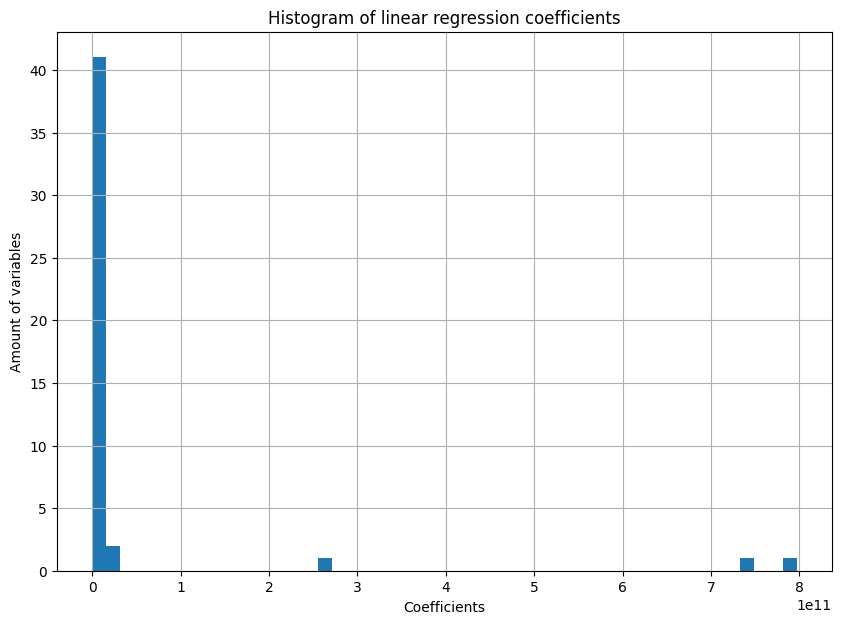

Based on our linear Regression, we have 35 features with coefficients <1


In [35]:
# We get the linear regression model from the pipeline
linear_reg_model = pipe.named_steps["linear_reg"]

# We get the feature names and coefficientes, creating a list of tuples
categorical_cols = list(X.select_dtypes(include="object").columns)
numerical_cols = list(X.select_dtypes(include=["int", "float"]).columns)
feature_names = categorical_cols + numerical_cols
coefficients = linear_reg_model.coef_
feature_coefficient_pairs = list(zip(feature_names, coefficients))

# We sort and them
feature_coefficient_pairs.sort(key=lambda x: abs(x[1]), reverse=True)
coefficients_df = pd.DataFrame(feature_coefficient_pairs, columns=["Feature", "Coefficient"])
coefficients_df["Coefficient"]=abs(coefficients_df["Coefficient"])

# We plot the histogram of values for a proper visualization and determination of importance threshold.
plt.figure(figsize=(10,7)) # increase the figure size
coefficients_df["Coefficient"].hist(bins=50)
plt.xlabel("Coefficients")
plt.ylabel("Amount of variables")
plt.title("Histogram of linear regression coefficients")
plt.show()

# Based on that, we create a list of variables with less than 1 in terms of importance.

unimportant=list(coefficients_df[coefficients_df["Coefficient"]<1]["Feature"])

print(f'Based on our linear Regression, we have {len(unimportant)} features with coefficients <1')

This allows us to see if the features are important. We plot the coefficients to establish a threshold that we will use to see that, if importance is low enough and the variable is correlated, we can eliminate it. **This plot and the threshold values selected may chnage across different countries datasets, so we must be wary of such selection**.

In [36]:
# We analyze multicollinearity by creating a temporary dataframe with encoding for exploration. We display the
# pairs graphically, and then, in a dataframe format to clean one of the variables with more than 75% of 
# correlation.

# We encode all categorical features, recovering df2 from before
categorical_cols = df2.select_dtypes(include='object').columns.tolist()
df2_encoded = pd.get_dummies(df2, columns=categorical_cols)
df2_encoded

,year,month,ged_state,ged_nonstate,ged_viol_tot,ged_viol_state,ged_viol_nonstate,acled_riots,acled_protests,pitf_state_inc,...,hdi_index,mountains_mean,ttime_mean,droughtstart_speibase,nearest_country_dist,own_borders_dist,target,lag1,lag2,lag3
0,2004,1,0,0,0,0,0,0.0,0.0,0.0,...,0.337,0.026944,2615.0090,-0.727961,2.944462,2.944462,0,NaN,NaN,NaN
246844,2004,1,0,0,0,0,0,0.0,0.0,0.0,...,0.337,0.000000,640.4086,1.037654,94.895130,94.895130,0,0.0,NaN,NaN
246843,2004,1,0,0,0,0,0,0.0,0.0,0.0,...,0.337,0.000000,640.4086,NaN,94.895130,94.895130,0,0.0,0.0,NaN
246842,2004,1,0,0,0,0,0,0.0,0.0,0.0,...,0.337,0.000000,640.4086,-0.213225,94.895130,94.895130,0,0.0,0.0,0.0
246841,2004,1,0,0,0,0,0,0.0,0.0,0.0,...,0.337,0.000000,640.4086,0.479621,94.895130,94.895130,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120506,2014,12,0,0,0,0,0,0.0,0.0,0.0,...,0.370,0.000000,1300.9210,NaN,42.005430,42.005430,0,0.0,0.0,0.0
120505,2014,12,0,0,0,0,0,0.0,0.0,0.0,...,0.370,0.000000,1300.9210,0.499010,42.005430,42.005430,0,0.0,0.0,0.0
271523,2014,12,0,0,0,0,0,0.0,0.0,0.0,...,0.370,0.060556,1130.2310,0.806155,82.297140,82.297140,0,0.0,0.0,0.0
120510,2014,12,0,0,0,0,0,0.0,0.0,0.0,...,0.370,0.000000,1300.9210,0.281175,42.005430,42.005430,0,0.0,0.0,0.0


In [37]:
#We create the correlation matrix numerically without displaying it.

corr_matrix=df2_encoded.corr().round(2)

correlated_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)

# We get the pairs with correlation greater than a threshold (here, 0.75).
threshold = 0.75
correlated_pairs = correlated_pairs[correlated_pairs > threshold]

# We ddrop the diagonal values, with perfect correlation with the own variable.
correlated_pairs = correlated_pairs[correlated_pairs != 1]
print(correlated_pairs)

ged_viol_tot        ged_viol_nonstate     0.95
ged_viol_nonstate   ged_viol_tot          0.95
NDVI_mean           NDVI_max              0.94
NDVI_max            NDVI_mean             0.94
latitude            ndvi.year.avg.mean    0.88
ndvi.year.avg.mean  latitude              0.88
year                hdi_index             0.87
p.anom              spei                  0.87
latitude            precip.year.total     0.87
precip.year.total   latitude              0.87
hdi_index           year                  0.87
spei                p.anom                0.87
precip.year.total   ndvi.year.avg.mean    0.85
ndvi.year.avg.mean  precip.year.total     0.85
NDVI_mean           p.avg                 0.78
p.avg               NDVI_mean             0.78
NDVI_min            NDVI_mean             0.76
NDVI_mean           NDVI_min              0.76
dtype: float64


In [38]:
# Then, we treat this Series Index as a list, join them together and take out only those features that are
# unique, which can be carried out with the set() method.

correlated_variables=list(correlated_pairs.index)
correlated_variables

variables_repeated=[]
for pair in correlated_variables:
    variables_repeated.append(pair[0])
    variables_repeated.append(pair[1])

multicollinearity=list(set(variables_repeated))

print('We have {} correlated variables with Pearson >75%.'.format(len(multicollinearity)))

We have 13 correlated variables with Pearson >75%.


In [39]:
# Next step is based on taking out of the multicollinearity list those variables that are correlated
# in a high degree and that have a low importance. 

rubbish_variables=list(set(multicollinearity) & set(unimportant))
rubbish_variables

print(f'Variables >0.75 of correlation and <1 of coefficient are dropped, eliminating {len(rubbish_variables)}.')

Variables >0.75 of correlation and <1 of coefficient are dropped, eliminating 11.


### Variables elimination

In [40]:
#Variables elimination

df.drop(rubbish_variables, axis=1, inplace=True)

print(f'We end up with {df.shape[1]}.')

We end up with 36.


Up to here, we have not done any outlier elimination. Based on the value of data and an exploratory and iterative approach, we will first run the models without such elimination, and if results are outstanding, leave the data as it is.

It is important to note that the models we will run here are more complex than the previous linear regression. We must make sure that in running them, we create models that are able to grasp a wide range of forms (and therefore, the training time is substantially higher, specially in the ```RandomForestRegressor()```.

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## First Model: Random Forest Regressor

We start with a ```RandomForestRegressor()``` taking into account our cleaned dataset. We will perform a hyperparameterization with ```GridSearchCV()```, although reduced for the compurtational time required (higher than an hour). A complete list of the hyperparameters that can be applied can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

Then, we will check for overfitting graphs using both R-squared and Mean Squared Error, and we will display all the feature importances.

In [16]:
#Train-test split

X=df.drop("target", axis=1)
y=df["target"]

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [17]:
# We create the random forest regressor
scaler = StandardScaler()
rf_regressor = RandomForestRegressor()
steps = [("transformer", data_preparation(X)), ("scaler", scaler), ("random_forest", rf_regressor)]
pipe = Pipeline(steps)

# We then define the hyperparameters to tune
param_grid = {
    'random_forest__n_estimators': [100],
    'random_forest__max_depth': [None, 5, 10],
    'random_forest__min_samples_split': [5],
    'random_forest__min_samples_leaf': [1, 2],
    'random_forest__max_features': ['auto', 'sqrt']
}

# We create the GridSearchCV object with 3-fold cross-validation (optimization purposes)
grid_search = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# We get the best model and its corresponding parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# And use the best model to make predictions on the test data, ouputing the prediction metrics
y_pred = best_model.predict(X_test)
mse_forest = mean_squared_error(y_test, y_pred)
r2_forest = r2_score(y_test, y_pred)
print("Best Parameters:", best_params)
print("Mean Squared Error (MSE):", mse_forest)
print("R-squared:", r2_forest)

Best Parameters: {'random_forest__max_depth': None, 'random_forest__max_features': 'sqrt', 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 5, 'random_forest__n_estimators': 100}
Mean Squared Error (MSE): 0.23987109909078033
R-squared: 0.9825108373256667


### Checking for overfitting

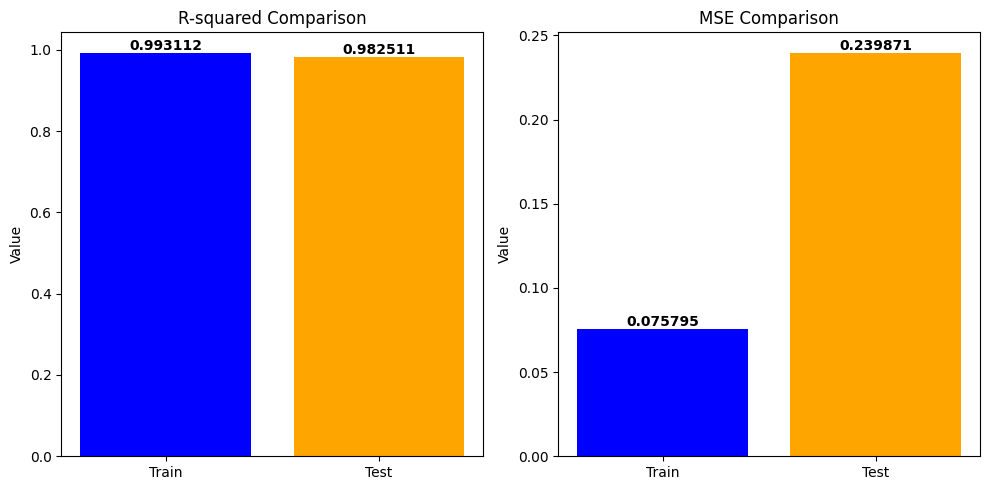

In [18]:
y_train_pred=best_model.predict(X_train)

# We calculate R-squared and MSEfor train and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_pred)

# We create bar plots for R-squared and MSE
metrics = ['Train', 'Test']  # Updated labels for columns
train_values = [r2_train, mse_train]
test_values = [r2_test, mse_test]

#R-squared
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.bar(metrics, [train_values[0], test_values[0]], color=['blue', 'orange'])
ax1.set_ylabel('Value')
ax1.set_title('R-squared Comparison')
for i, v in enumerate([train_values[0], test_values[0]]):
    ax1.text(i, v, str(round(v, 6)), ha='center', va='bottom', fontweight='bold')

# MSE
ax2.bar(metrics, [train_values[1], test_values[1]], color=['blue', 'orange'])
ax2.set_ylabel('Value')
ax2.set_title('MSE Comparison')
for i, v in enumerate([train_values[1], test_values[1]]):
    ax2.text(i, v, str(round(v, 6)), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Feature Importance:
lag1 : 0.16552700971032355
ged_viol_tot : 0.15618200847874172
ged_viol_nonstate : 0.10124154303749605
ged_state : 0.06501307213503504
lag2 : 0.058671916599420136
lag3 : 0.05023889752368185
pitf_multiple_inc : 0.04696120237011195
ged_viol_state : 0.046394698056239844
longitude : 0.039371271973775025
nearest_country_dist : 0.03267115817825534
ged_nonstate : 0.032485263030750236
t.anom : 0.030429579066751117
t.c.avg : 0.030152064149501452
population : 0.0269597154543247
ttime_mean : 0.023183513197107344
own_borders_dist : 0.020745007647512685
month : 0.019014657285414887
mountains_mean : 0.015927175864962746
NL_sum : 0.01423800785067295
pitf_state_inc : 0.009089404791932286
droughtstart_speibase : 0.004842698021441487
pitf_multiple_camp : 0.004201995087313444
pitf_nonstate_inc : 0.00282982006363384
acled_riots : 0.001843306553059535
acled_protests : 0.0015240689315552014
pitf_trans_inc : 0.0002410121074752666
pitf_nonstate_camp : 1.9932833510163492e-05
pitf_state_camp 

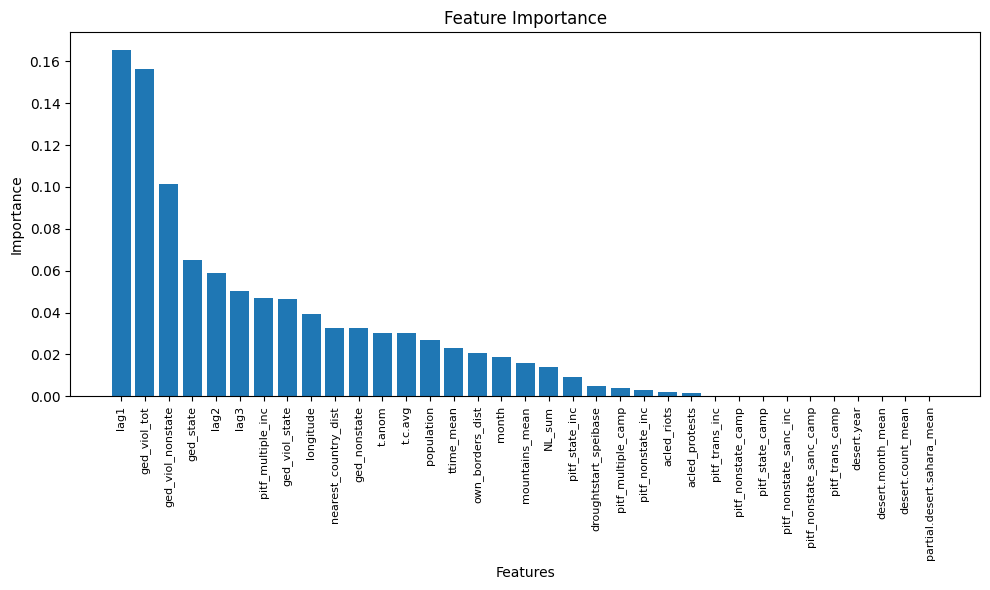

In [19]:
# We fit the best model on the entire training data
best_model.fit(X_train, y_train)

#We extract feature importances
importance = best_model.named_steps['random_forest'].feature_importances_
feature_importance_dict = dict(zip(X.columns, importance))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importance:")
for feature, importance in sorted_feature_importance:
    print(feature, ":", importance)

# And we plot them
features = [item[0] for item in sorted_feature_importance]
importances = [item[1] for item in sorted_feature_importance]
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(range(len(features)), importances)
plt.xticks(range(len(features)), features, rotation=90, fontsize=8)  # Smaller x-labels with fontsize=8
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()  # Adjust the spacing of the plot elements
plt.show()

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Second Model: Gradient Boosted Tree

In this case, there will be no hyperparameterization, although we will integrate the functionality of ```XGBRegressor()``` inside Scikit-learn structures.

As the model is more nimble, we will analyze overfitting and feature importance lists for each one of the 12 months, as well as plotting all the features importance for each model.

In [20]:
#Train-test split

X=df.drop("target", axis=1)
y=df["target"]

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [21]:
#Model creation with the data_preparation function

scaler = StandardScaler()
boosted=XGBRegressor(objective='reg:squarederror')
steps = [("transformer", data_preparation(X)), ("scaler", scaler), ("model", boosted)]
pipe = Pipeline(steps)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

mse_boosted = mean_squared_error(y_test, y_pred)
r2_boosted = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse_boosted)
print("R-squared:", r2_boosted)

Mean Squared Error: 0.20777092003511927
R-squared: 0.984851282904595


### Checking for overfitting

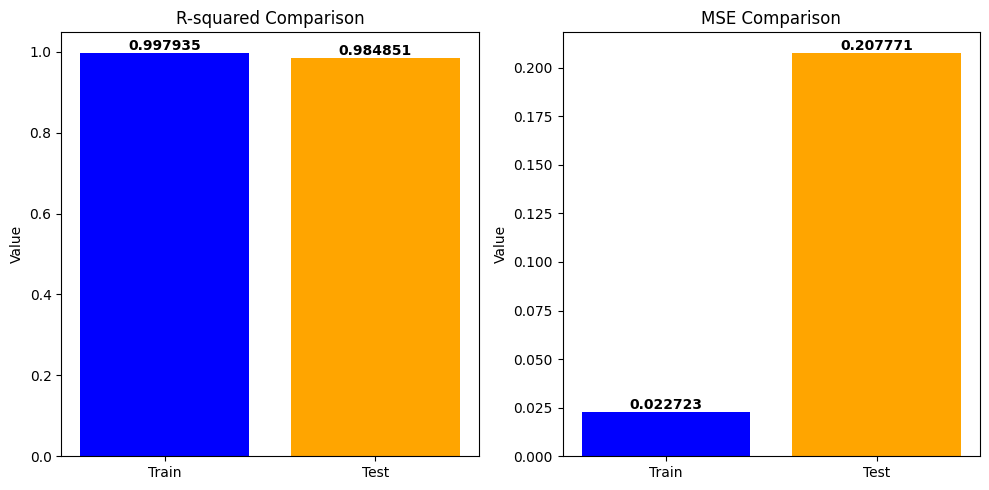

In [22]:
y_train_pred=pipe.predict(X_train)

# Calculate R-squared for train and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred)

# Calculate MSE for train and test sets
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_pred)

# Create bar plots for R-squared and MSE
metrics = ['Train', 'Test']  # Updated labels for columns
train_values = [r2_train, mse_train]
test_values = [r2_test, mse_test]

# Plotting the side-by-side bar plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Bar plot for R-squared
ax1.bar(metrics, [train_values[0], test_values[0]], color=['blue', 'orange'])
ax1.set_ylabel('Value')
ax1.set_title('R-squared Comparison')

# Add text labels on top of each column
for i, v in enumerate([train_values[0], test_values[0]]):
    ax1.text(i, v, str(round(v, 6)), ha='center', va='bottom', fontweight='bold')

# Bar plot for MSE
ax2.bar(metrics, [train_values[1], test_values[1]], color=['blue', 'orange'])
ax2.set_ylabel('Value')
ax2.set_title('MSE Comparison')

# Add text labels on top of each column
for i, v in enumerate([train_values[1], test_values[1]]):
    ax2.text(i, v, str(round(v, 6)), ha='center', va='bottom', fontweight='bold')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

Feature Importance:
ged_viol_tot : 0.39531648
lag1 : 0.18112151
ged_nonstate : 0.06840717
ged_state : 0.06054849
ged_viol_state : 0.050352003
longitude : 0.03894257
t.c.avg : 0.03446714
population : 0.033991385
ged_viol_nonstate : 0.025439143
month : 0.02325197
ttime_mean : 0.020256286
t.anom : 0.016964627
nearest_country_dist : 0.014152066
pitf_state_inc : 0.01116457
lag3 : 0.009303961
NL_sum : 0.007856764
lag2 : 0.0028698572
acled_protests : 0.0020126593
pitf_nonstate_inc : 0.00089461537
mountains_mean : 0.00071193615
pitf_trans_inc : 0.0006469735
droughtstart_speibase : 0.00053401885
pitf_multiple_camp : 0.00043154776
acled_riots : 0.00029339892
pitf_nonstate_camp : 6.886139e-05
pitf_state_camp : 0.0
pitf_nonstate_sanc_inc : 0.0
pitf_nonstate_sanc_camp : 0.0
pitf_multiple_inc : 0.0
pitf_trans_camp : 0.0
desert.year : 0.0
desert.month_mean : 0.0
desert.count_mean : 0.0
partial.desert.sahara_mean : 0.0
own_borders_dist : 0.0


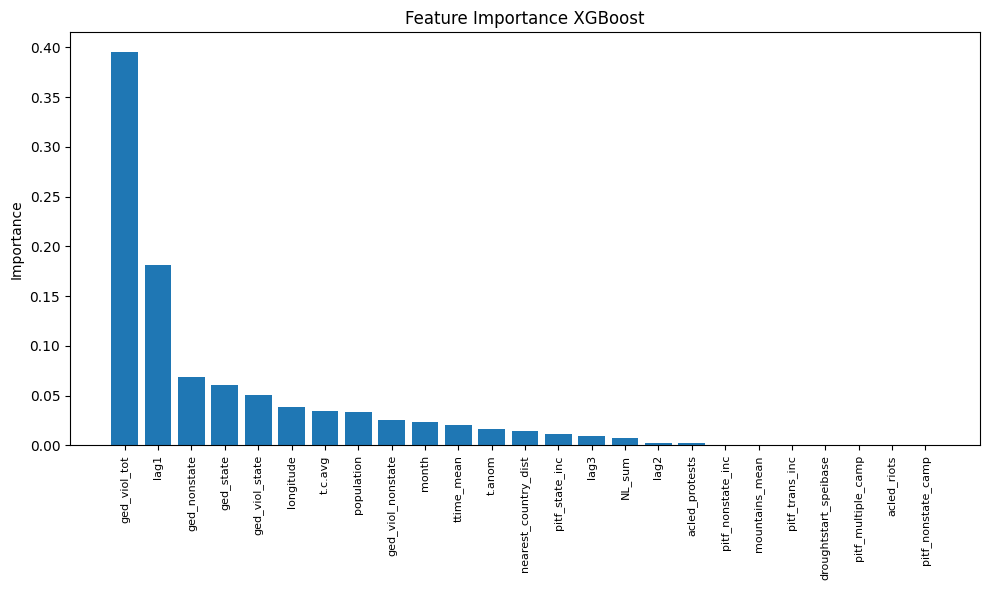

In [23]:
# We extract feature importance from the XGBoost model
importance = pipe.named_steps['model'].feature_importances_

# We put a dictionary to store the values
feature_importance_dict = dict(zip(X.columns, importance))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# We print the feature importance list
print("Feature Importance:")
for feature, importance in sorted_feature_importance:
    print(feature, ":", importance)

# Filter out variables with importance equal to 0
filtered_feature_importance = [(feature, importance) for feature, importance in sorted_feature_importance if importance != 0]

# Extract feature names and importances for plotting
features = [item[0] for item in filtered_feature_importance]
importances = [item[1] for item in filtered_feature_importance]

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(range(len(features)), importances)
plt.xticks(range(len(features)), features, rotation=90, fontsize=8)
plt.ylabel('Importance')
plt.title('Feature Importance XGBoost')
plt.tight_layout()
plt.show()

### What if we try one Gradient Boosted Tree for each month (model that allows to optimize computing)?

Month: 1
Mean Squared Error: 0.00013111402388723016
R-squared: 0.9999930611015643


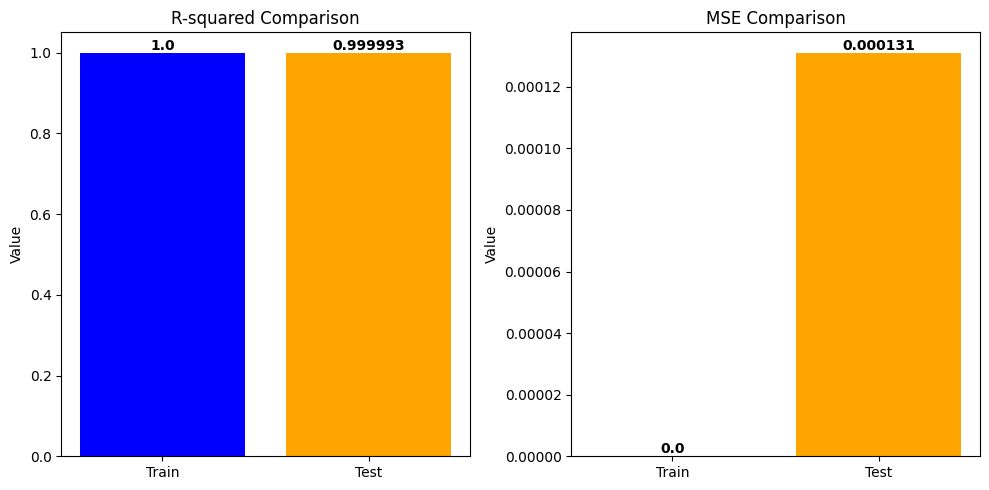

Feature Importance for month 1:
ged_viol_nonstate : 0.8745055
ged_nonstate : 0.08795493
ged_viol_state : 0.02419295
population : 0.0061351764
ged_viol_tot : 0.0022586705
longitude : 0.001528371
lag1 : 0.0012247948
ged_state : 0.0011729196
NL_sum : 0.0003277428
nearest_country_dist : 0.00028514554
acled_riots : 0.00023626807
t.c.avg : 7.561861e-05
ttime_mean : 6.931049e-05
t.anom : 3.0164869e-05
droughtstart_speibase : 2.1593828e-06
pitf_nonstate_camp : 2.0046751e-07
mountains_mean : 1.2846526e-07
lag2 : 8.167521e-11
month : 0.0
acled_protests : 0.0
pitf_state_inc : 0.0
pitf_state_camp : 0.0
pitf_nonstate_sanc_inc : 0.0
pitf_nonstate_sanc_camp : 0.0
pitf_nonstate_inc : 0.0
pitf_multiple_inc : 0.0
pitf_multiple_camp : 0.0
pitf_trans_inc : 0.0
pitf_trans_camp : 0.0
desert.year : 0.0
desert.month_mean : 0.0
desert.count_mean : 0.0
partial.desert.sahara_mean : 0.0
own_borders_dist : 0.0
lag3 : 0.0


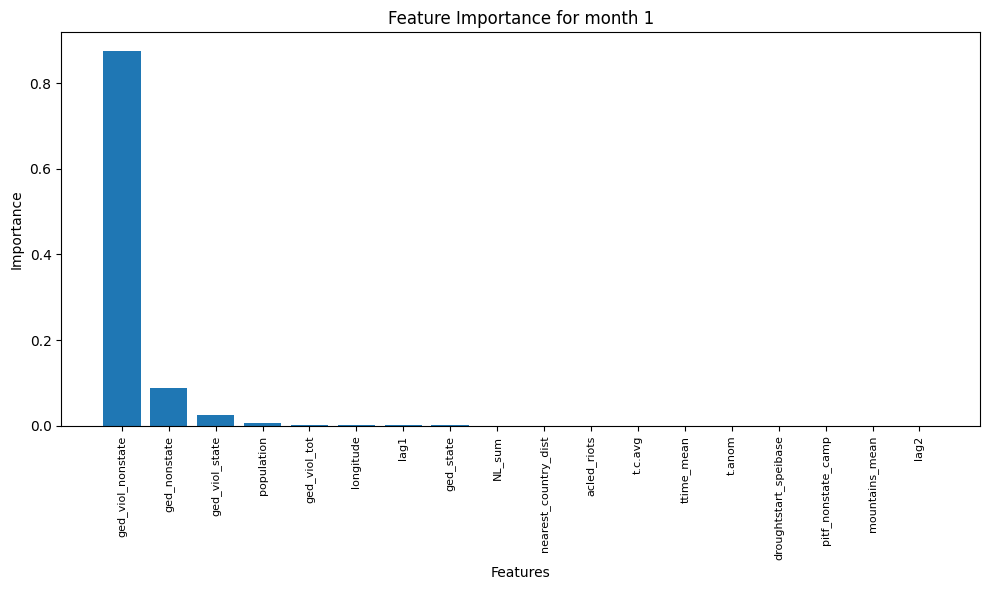

Month: 2
Mean Squared Error: 0.15035444155618685
R-squared: 0.986642656405125


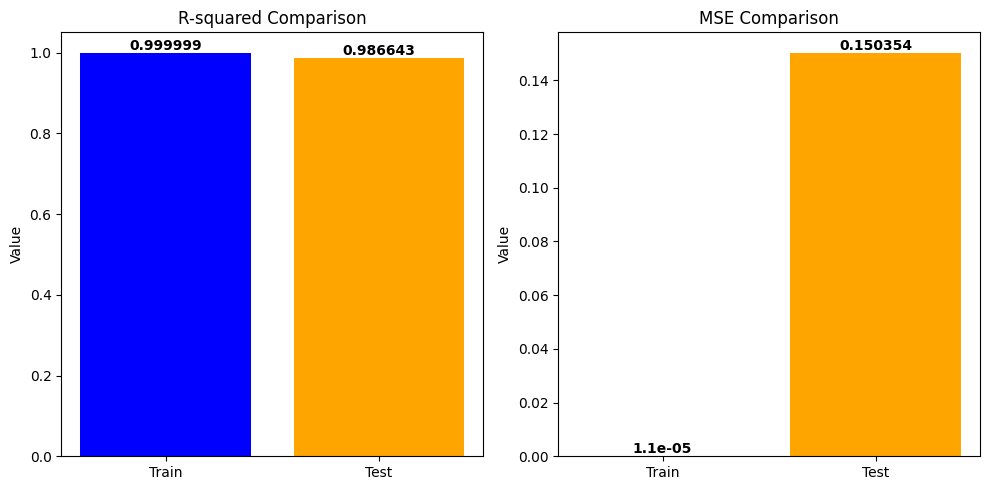

Feature Importance for month 2:
acled_riots : 0.29583633
ged_viol_tot : 0.28785023
t.c.avg : 0.09894648
ged_state : 0.09714316
ged_viol_state : 0.09514896
ttime_mean : 0.04696303
lag1 : 0.034996893
nearest_country_dist : 0.0128417965
longitude : 0.008499951
t.anom : 0.008220814
population : 0.0070171817
ged_nonstate : 0.00285351
mountains_mean : 0.0021835046
NL_sum : 0.0010714476
ged_viol_nonstate : 0.00023414394
droughtstart_speibase : 0.00014169664
lag2 : 2.96463e-05
lag3 : 2.125348e-05
month : 0.0
acled_protests : 0.0
pitf_state_inc : 0.0
pitf_state_camp : 0.0
pitf_nonstate_sanc_inc : 0.0
pitf_nonstate_sanc_camp : 0.0
pitf_nonstate_inc : 0.0
pitf_nonstate_camp : 0.0
pitf_multiple_inc : 0.0
pitf_multiple_camp : 0.0
pitf_trans_inc : 0.0
pitf_trans_camp : 0.0
desert.year : 0.0
desert.month_mean : 0.0
desert.count_mean : 0.0
partial.desert.sahara_mean : 0.0
own_borders_dist : 0.0


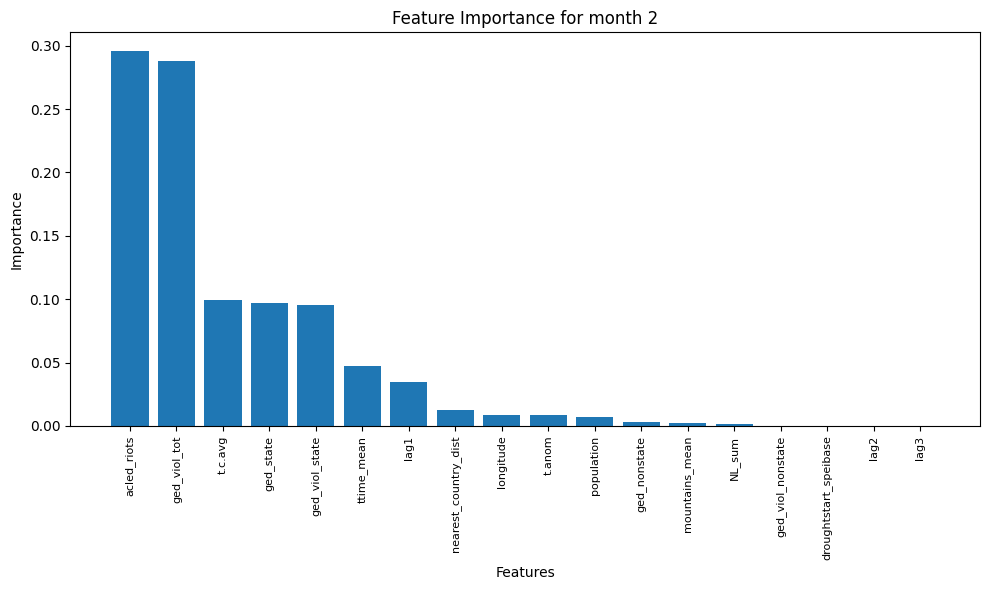

Month: 3
Mean Squared Error: 0.00832532850539533
R-squared: 0.9924991240756219


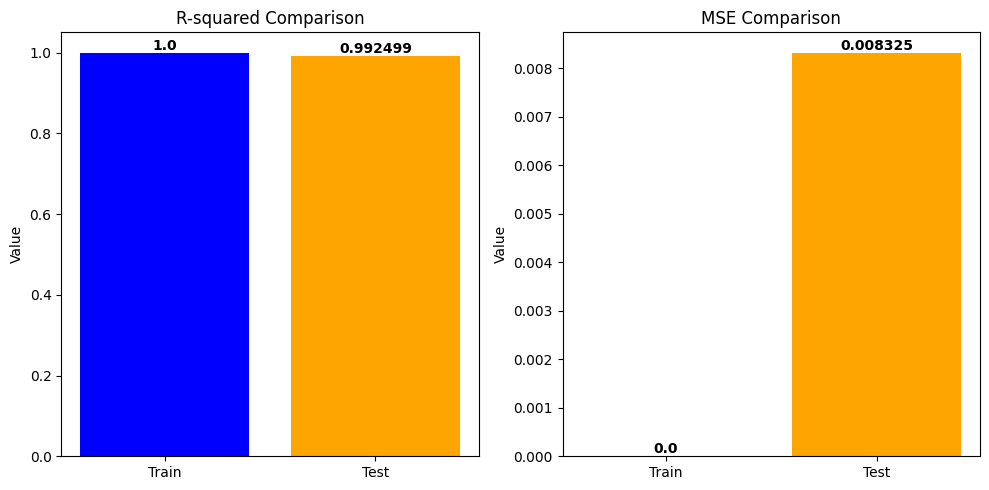

Feature Importance for month 3:
ged_state : 0.7850264
ged_viol_tot : 0.076635465
ttime_mean : 0.047073394
NL_sum : 0.033352822
population : 0.017745208
lag1 : 0.0157688
nearest_country_dist : 0.007734572
t.c.avg : 0.0073275766
ged_viol_nonstate : 0.004214293
longitude : 0.002243307
ged_nonstate : 0.0011575962
t.anom : 0.0009730801
ged_viol_state : 0.0005544783
mountains_mean : 0.0001763242
droughtstart_speibase : 1.4035111e-05
lag2 : 1.9636109e-06
lag3 : 7.9565893e-07
month : 0.0
acled_riots : 0.0
acled_protests : 0.0
pitf_state_inc : 0.0
pitf_state_camp : 0.0
pitf_nonstate_sanc_inc : 0.0
pitf_nonstate_sanc_camp : 0.0
pitf_nonstate_inc : 0.0
pitf_nonstate_camp : 0.0
pitf_multiple_inc : 0.0
pitf_multiple_camp : 0.0
pitf_trans_inc : 0.0
pitf_trans_camp : 0.0
desert.year : 0.0
desert.month_mean : 0.0
desert.count_mean : 0.0
partial.desert.sahara_mean : 0.0
own_borders_dist : 0.0


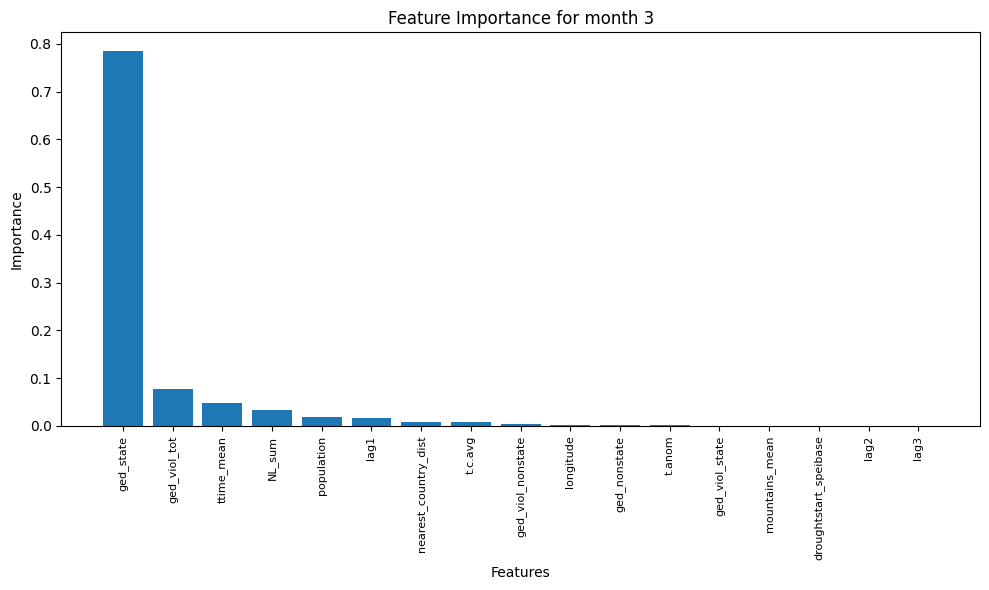

Month: 4
Mean Squared Error: 0.01325618726874113
R-squared: 0.9901208065132181


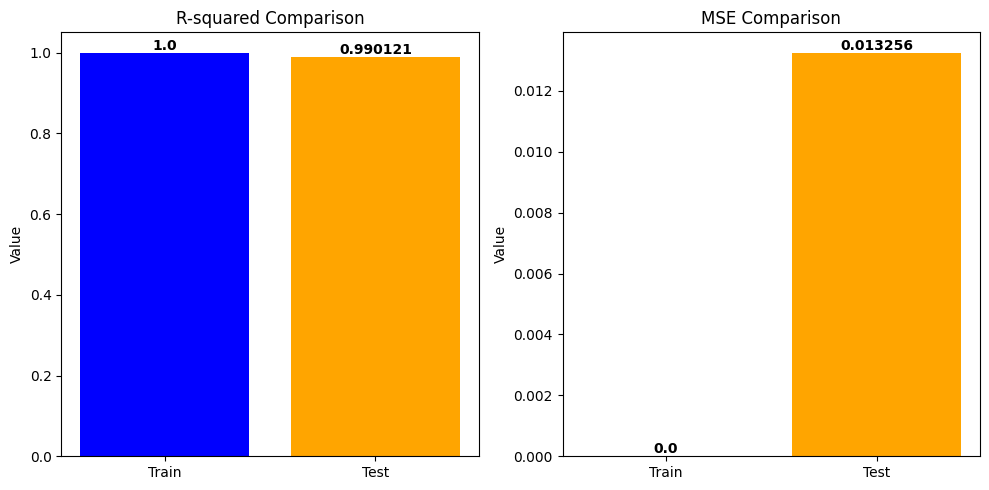

Feature Importance for month 4:
ged_state : 0.42526028
lag1 : 0.2821102
t.c.avg : 0.14209457
population : 0.06356362
ged_viol_tot : 0.057222873
t.anom : 0.01976147
droughtstart_speibase : 0.0050099553
longitude : 0.0017635832
ged_viol_nonstate : 0.0016583897
NL_sum : 0.0007869933
ged_viol_state : 0.00031055795
ged_nonstate : 0.00026319132
nearest_country_dist : 0.00015305504
ttime_mean : 3.8759885e-05
lag2 : 1.6414195e-06
lag3 : 5.560968e-07
mountains_mean : 2.7671567e-07
pitf_nonstate_inc : 3.2729135e-09
month : 0.0
acled_riots : 0.0
acled_protests : 0.0
pitf_state_inc : 0.0
pitf_state_camp : 0.0
pitf_nonstate_sanc_inc : 0.0
pitf_nonstate_sanc_camp : 0.0
pitf_nonstate_camp : 0.0
pitf_multiple_inc : 0.0
pitf_multiple_camp : 0.0
pitf_trans_inc : 0.0
pitf_trans_camp : 0.0
desert.year : 0.0
desert.month_mean : 0.0
desert.count_mean : 0.0
partial.desert.sahara_mean : 0.0
own_borders_dist : 0.0


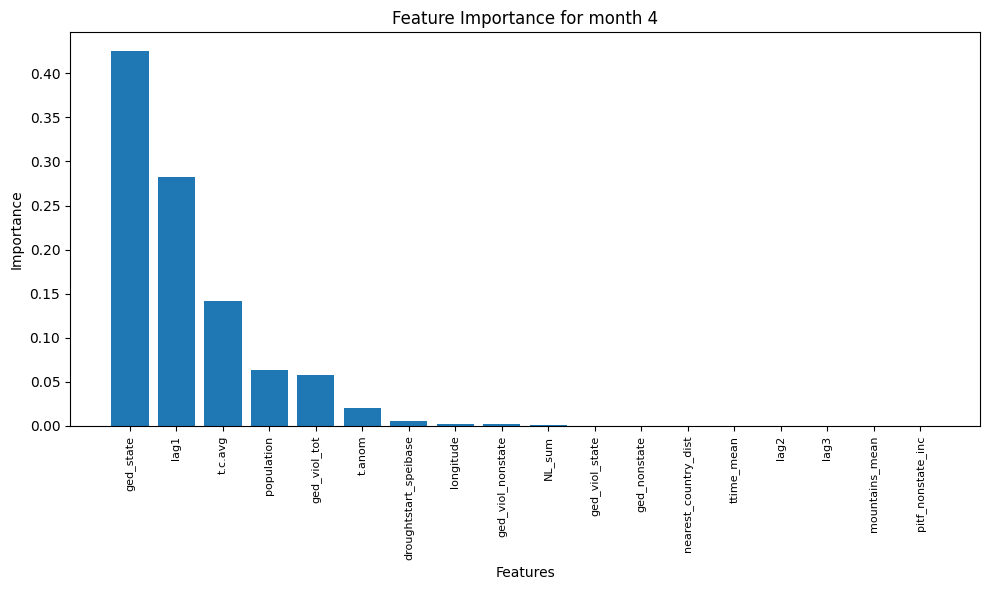

Month: 5
Mean Squared Error: 8.113995500291496e-09
R-squared: 0.999999973450292


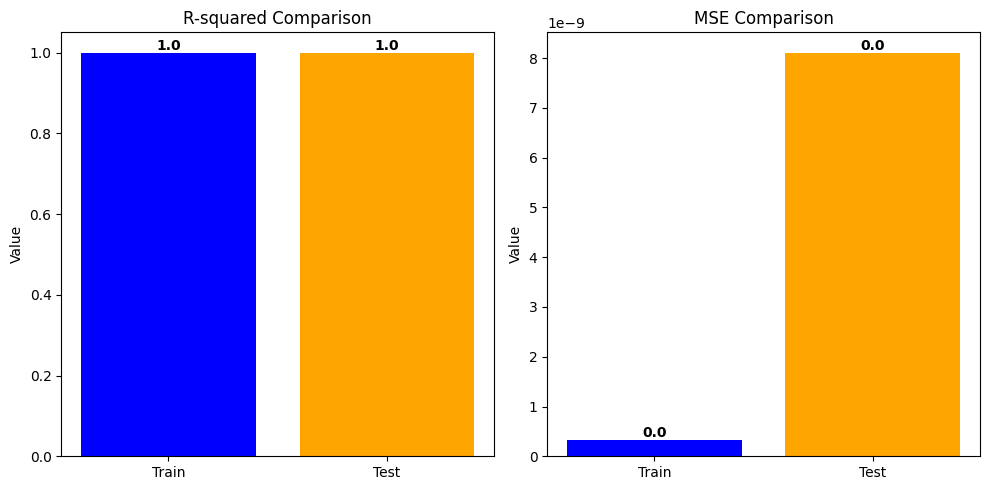

Feature Importance for month 5:
ged_viol_tot : 0.41756672
mountains_mean : 0.24574706
ged_nonstate : 0.19189478
population : 0.054471806
nearest_country_dist : 0.05156241
ged_viol_state : 0.019646728
t.c.avg : 0.0146524515
acled_riots : 0.0038687096
lag1 : 0.0004233892
NL_sum : 0.00016576641
lag3 : 1.9170574e-07
t.anom : 1.2956374e-07
month : 0.0
ged_state : 0.0
ged_viol_nonstate : 0.0
acled_protests : 0.0
pitf_state_inc : 0.0
pitf_state_camp : 0.0
pitf_nonstate_sanc_inc : 0.0
pitf_nonstate_sanc_camp : 0.0
pitf_nonstate_inc : 0.0
pitf_nonstate_camp : 0.0
pitf_multiple_inc : 0.0
pitf_multiple_camp : 0.0
pitf_trans_inc : 0.0
pitf_trans_camp : 0.0
longitude : 0.0
desert.year : 0.0
desert.month_mean : 0.0
desert.count_mean : 0.0
partial.desert.sahara_mean : 0.0
ttime_mean : 0.0
droughtstart_speibase : 0.0
own_borders_dist : 0.0
lag2 : 0.0


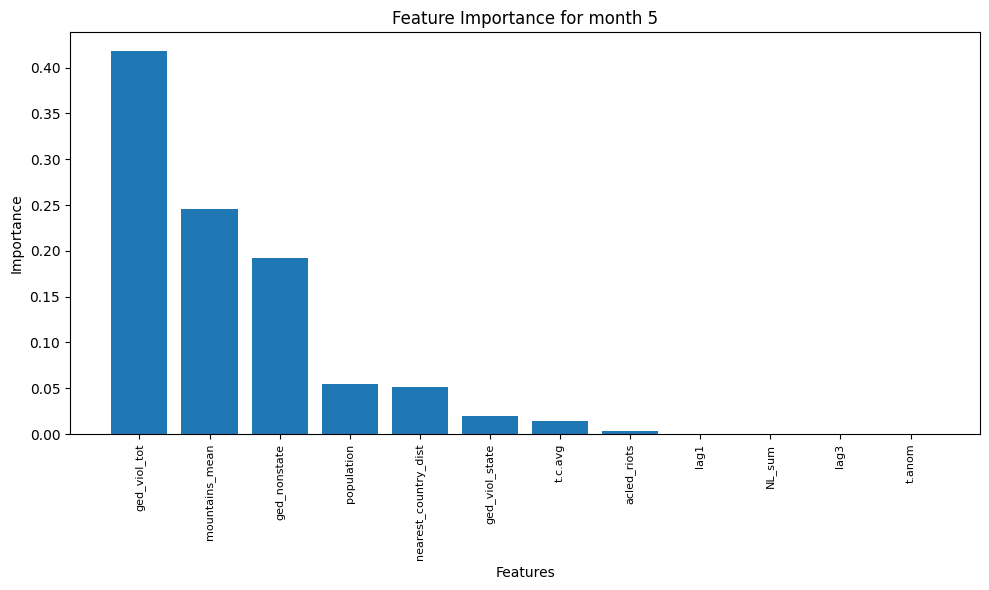

Month: 6
Mean Squared Error: 0.012244878813453127
R-squared: 0.9981970736536228


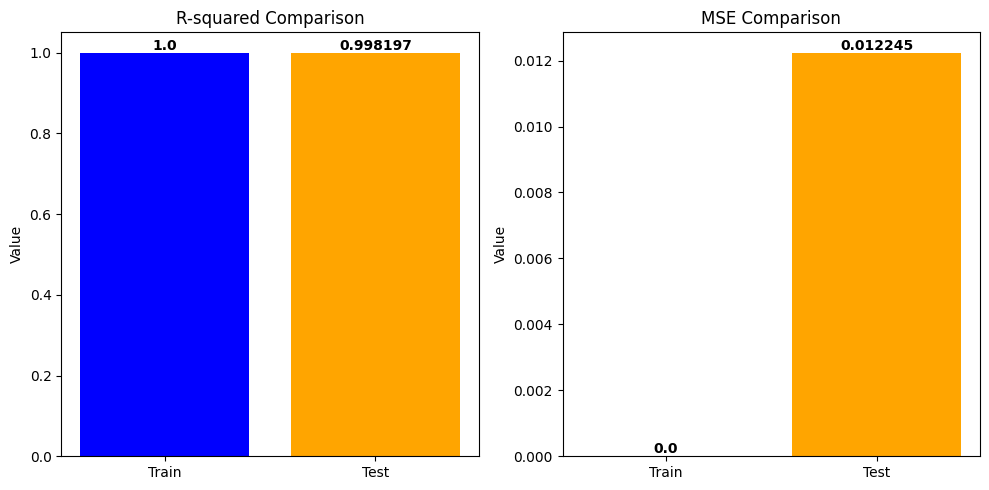

Feature Importance for month 6:
ged_nonstate : 0.74934256
ged_viol_nonstate : 0.06746566
lag1 : 0.054593235
ged_state : 0.047815554
ttime_mean : 0.027787989
nearest_country_dist : 0.021006389
ged_viol_tot : 0.015491212
population : 0.0071346387
pitf_nonstate_inc : 0.0037506085
t.c.avg : 0.0023152884
NL_sum : 0.0020065436
t.anom : 0.0008835259
lag2 : 0.0002420296
longitude : 0.00011721289
droughtstart_speibase : 4.0497274e-05
ged_viol_state : 3.7631148e-06
lag3 : 3.1493812e-06
mountains_mean : 6.474118e-08
month : 0.0
acled_riots : 0.0
acled_protests : 0.0
pitf_state_inc : 0.0
pitf_state_camp : 0.0
pitf_nonstate_sanc_inc : 0.0
pitf_nonstate_sanc_camp : 0.0
pitf_nonstate_camp : 0.0
pitf_multiple_inc : 0.0
pitf_multiple_camp : 0.0
pitf_trans_inc : 0.0
pitf_trans_camp : 0.0
desert.year : 0.0
desert.month_mean : 0.0
desert.count_mean : 0.0
partial.desert.sahara_mean : 0.0
own_borders_dist : 0.0


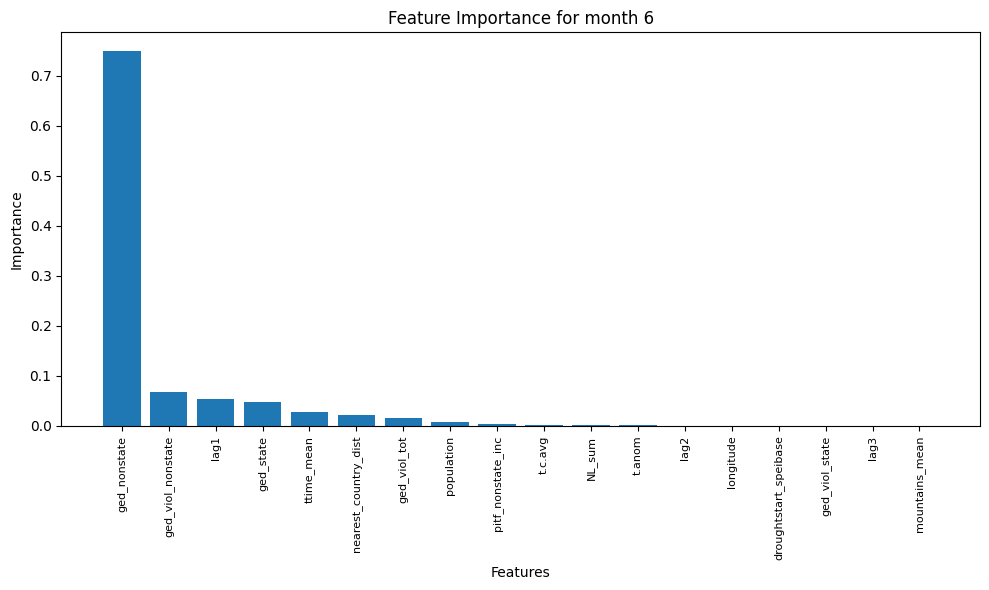

Month: 7
Mean Squared Error: 2.1200529690199946e-10
R-squared: 0.9999999999764524


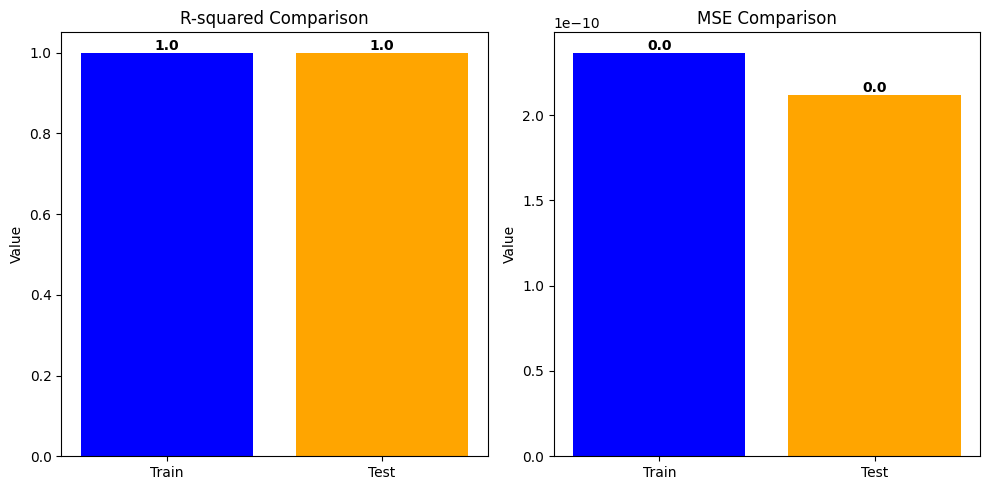

Feature Importance for month 7:
ged_viol_state : 0.9828018
ged_viol_tot : 0.015499055
ttime_mean : 0.0015041068
ged_state : 6.955166e-05
t.anom : 4.969585e-05
population : 4.6706406e-05
ged_nonstate : 2.9078568e-05
acled_protests : 8.496465e-11
pitf_nonstate_inc : 7.770373e-11
lag1 : 6.05968e-11
month : 0.0
ged_viol_nonstate : 0.0
acled_riots : 0.0
pitf_state_inc : 0.0
pitf_state_camp : 0.0
pitf_nonstate_sanc_inc : 0.0
pitf_nonstate_sanc_camp : 0.0
pitf_nonstate_camp : 0.0
pitf_multiple_inc : 0.0
pitf_multiple_camp : 0.0
pitf_trans_inc : 0.0
pitf_trans_camp : 0.0
t.c.avg : 0.0
NL_sum : 0.0
longitude : 0.0
desert.year : 0.0
desert.month_mean : 0.0
desert.count_mean : 0.0
partial.desert.sahara_mean : 0.0
mountains_mean : 0.0
droughtstart_speibase : 0.0
nearest_country_dist : 0.0
own_borders_dist : 0.0
lag2 : 0.0
lag3 : 0.0


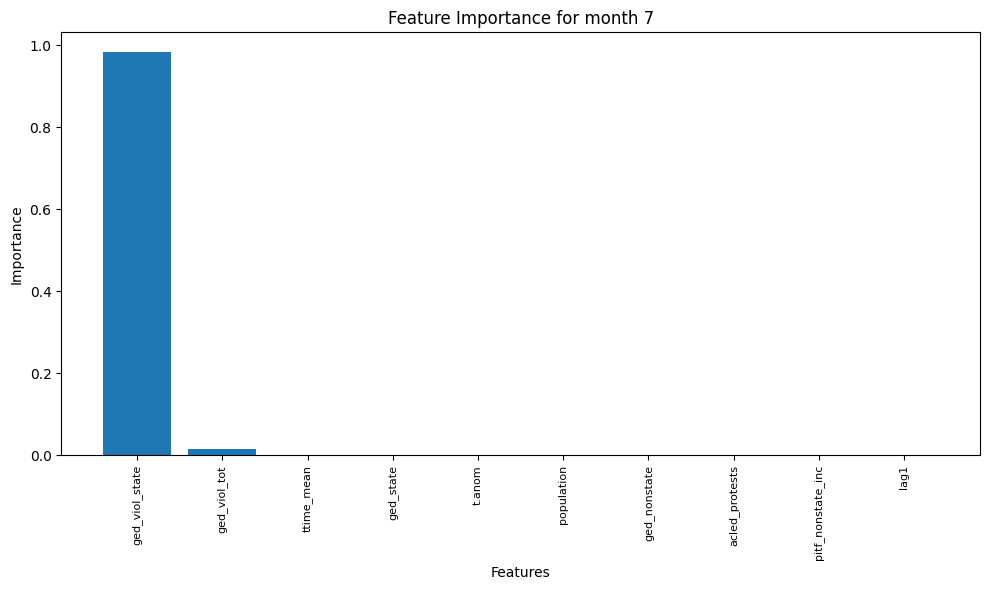

Month: 8
Mean Squared Error: 0.026395320680685896
R-squared: 0.9978317774230253


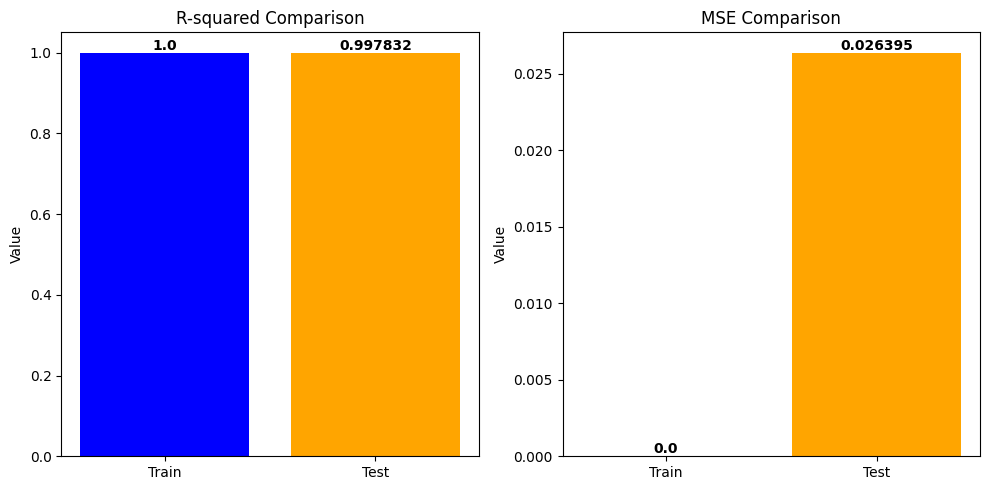

Feature Importance for month 8:
lag1 : 0.46731842
ged_state : 0.32419688
population : 0.16361018
ged_viol_tot : 0.027229035
ged_viol_state : 0.007655673
t.c.avg : 0.0050508985
nearest_country_dist : 0.0032281943
droughtstart_speibase : 0.000817434
ttime_mean : 0.00041618713
pitf_nonstate_camp : 0.0002980658
t.anom : 0.0001777889
ged_nonstate : 6.358044e-07
longitude : 4.1528008e-07
lag2 : 2.1525949e-07
lag3 : 2.338201e-08
NL_sum : 1.0994635e-08
month : 0.0
ged_viol_nonstate : 0.0
acled_riots : 0.0
acled_protests : 0.0
pitf_state_inc : 0.0
pitf_state_camp : 0.0
pitf_nonstate_sanc_inc : 0.0
pitf_nonstate_sanc_camp : 0.0
pitf_nonstate_inc : 0.0
pitf_multiple_inc : 0.0
pitf_multiple_camp : 0.0
pitf_trans_inc : 0.0
pitf_trans_camp : 0.0
desert.year : 0.0
desert.month_mean : 0.0
desert.count_mean : 0.0
partial.desert.sahara_mean : 0.0
mountains_mean : 0.0
own_borders_dist : 0.0


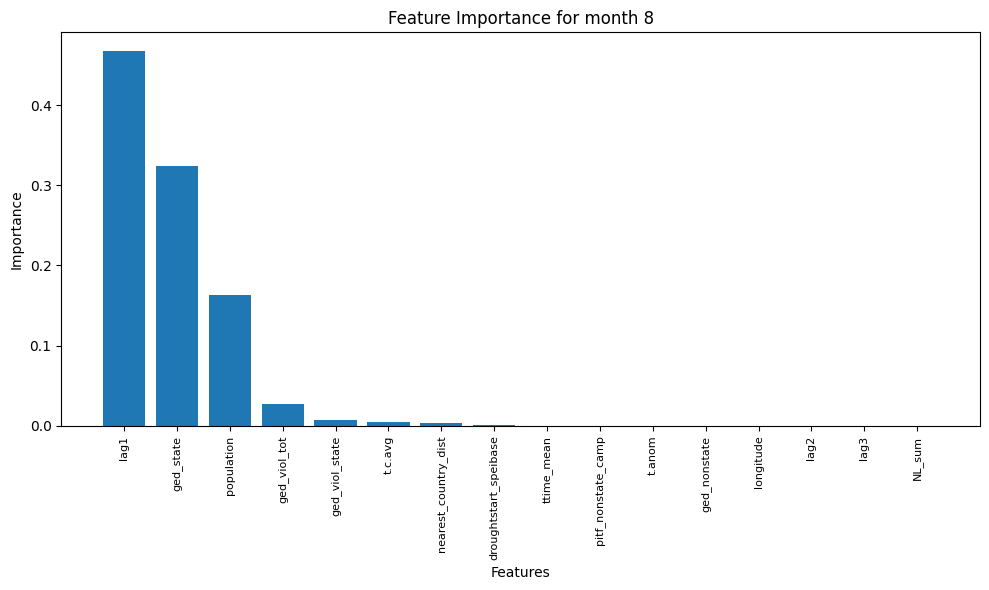

Month: 9
Mean Squared Error: 0.0002876448593634926
R-squared: 0.9999922726453321


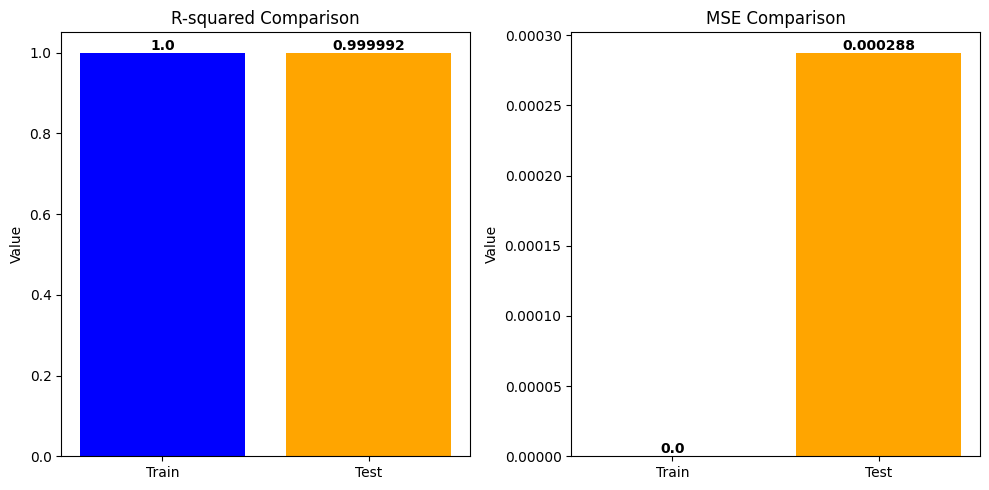

Feature Importance for month 9:
ged_state : 0.89094186
longitude : 0.057480905
ged_viol_tot : 0.04613081
ttime_mean : 0.003104946
t.anom : 0.00092656293
nearest_country_dist : 0.0007995926
ged_viol_state : 0.00030185166
population : 0.00028213926
t.c.avg : 1.4361603e-05
pitf_nonstate_inc : 7.944953e-06
lag1 : 4.356461e-06
NL_sum : 3.8506637e-06
ged_viol_nonstate : 4.083497e-07
ged_nonstate : 3.247631e-07
droughtstart_speibase : 8.24459e-08
lag3 : 4.6926324e-08
lag2 : 2.2866638e-08
mountains_mean : 4.338651e-09
month : 0.0
acled_riots : 0.0
acled_protests : 0.0
pitf_state_inc : 0.0
pitf_state_camp : 0.0
pitf_nonstate_sanc_inc : 0.0
pitf_nonstate_sanc_camp : 0.0
pitf_nonstate_camp : 0.0
pitf_multiple_inc : 0.0
pitf_multiple_camp : 0.0
pitf_trans_inc : 0.0
pitf_trans_camp : 0.0
desert.year : 0.0
desert.month_mean : 0.0
desert.count_mean : 0.0
partial.desert.sahara_mean : 0.0
own_borders_dist : 0.0


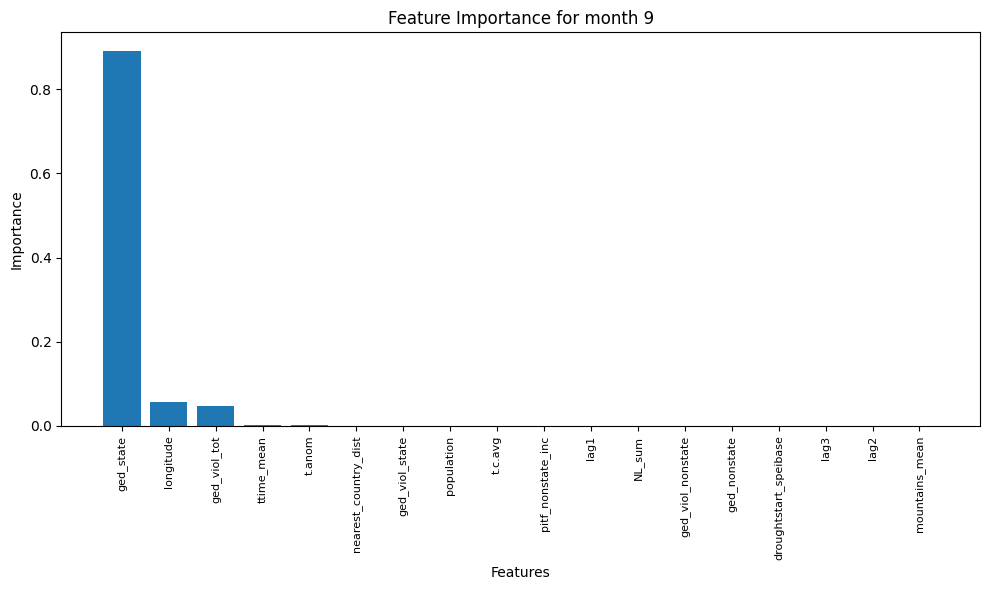

Month: 10
Mean Squared Error: 3.3916007363482624e-09
R-squared: 0.9999999994631585


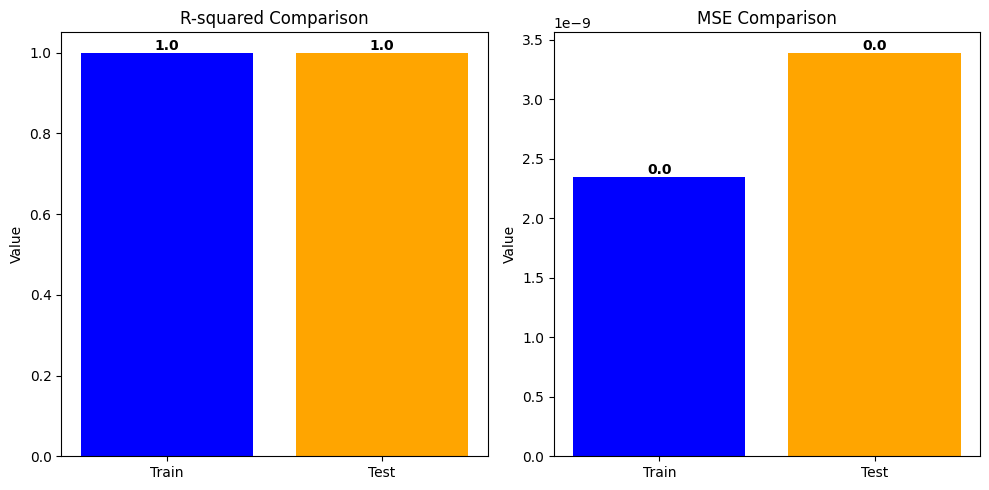

Feature Importance for month 10:
ged_state : 0.8359763
t.c.avg : 0.083820075
ged_viol_tot : 0.031358954
population : 0.024998968
pitf_state_inc : 0.011805015
ged_viol_nonstate : 0.010201465
ged_viol_state : 0.0012447549
ged_nonstate : 0.0004080906
longitude : 0.00016135334
nearest_country_dist : 2.1359278e-05
lag1 : 2.0735454e-06
acled_riots : 1.5827303e-06
droughtstart_speibase : 9.120431e-09
lag2 : 5.971779e-10
month : 0.0
acled_protests : 0.0
pitf_state_camp : 0.0
pitf_nonstate_sanc_inc : 0.0
pitf_nonstate_sanc_camp : 0.0
pitf_nonstate_inc : 0.0
pitf_nonstate_camp : 0.0
pitf_multiple_inc : 0.0
pitf_multiple_camp : 0.0
pitf_trans_inc : 0.0
pitf_trans_camp : 0.0
t.anom : 0.0
NL_sum : 0.0
desert.year : 0.0
desert.month_mean : 0.0
desert.count_mean : 0.0
partial.desert.sahara_mean : 0.0
mountains_mean : 0.0
ttime_mean : 0.0
own_borders_dist : 0.0
lag3 : 0.0


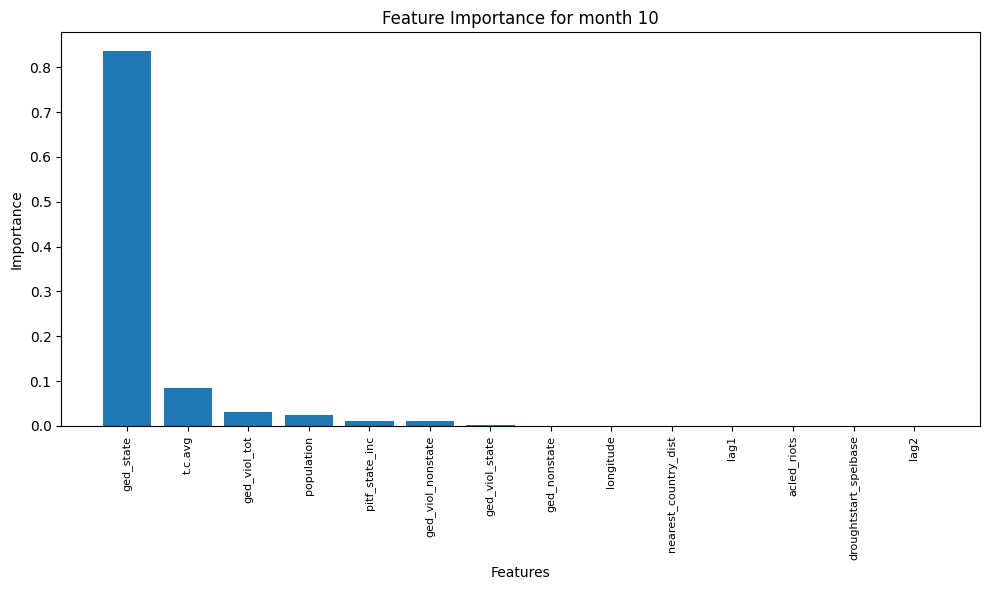

Month: 11
Mean Squared Error: 4.182006732195469e-07
R-squared: 0.9999997878973861


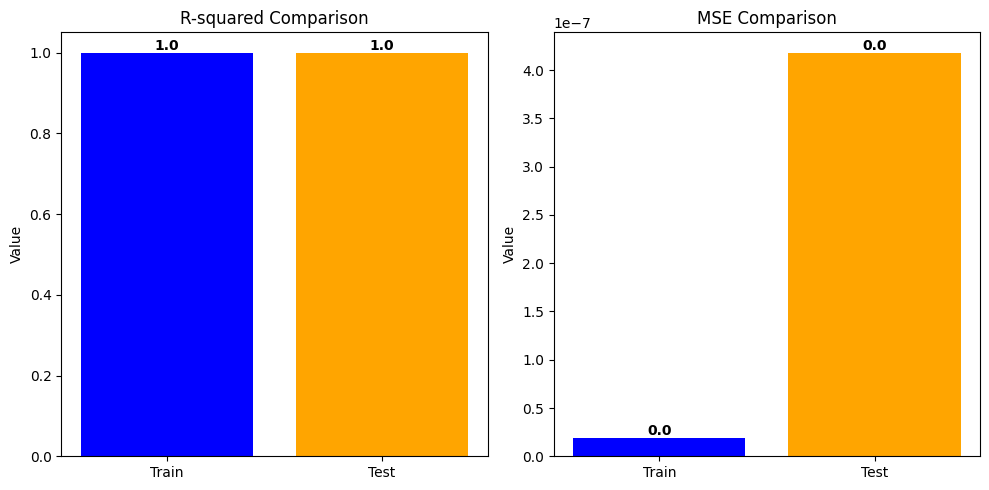

Feature Importance for month 11:
ged_viol_nonstate : 0.35762063
ttime_mean : 0.20336144
ged_state : 0.09966059
lag1 : 0.08751745
ged_nonstate : 0.051443562
t.c.avg : 0.041198414
t.anom : 0.038168333
NL_sum : 0.03792125
ged_viol_tot : 0.031876948
longitude : 0.027494952
population : 0.023735564
lag2 : 3.196875e-07
ged_viol_state : 2.8715243e-07
droughtstart_speibase : 2.832459e-07
pitf_trans_inc : 5.4471016e-08
lag3 : 1.2599516e-08
month : 0.0
acled_riots : 0.0
acled_protests : 0.0
pitf_state_inc : 0.0
pitf_state_camp : 0.0
pitf_nonstate_sanc_inc : 0.0
pitf_nonstate_sanc_camp : 0.0
pitf_nonstate_inc : 0.0
pitf_nonstate_camp : 0.0
pitf_multiple_inc : 0.0
pitf_multiple_camp : 0.0
pitf_trans_camp : 0.0
desert.year : 0.0
desert.month_mean : 0.0
desert.count_mean : 0.0
partial.desert.sahara_mean : 0.0
mountains_mean : 0.0
nearest_country_dist : 0.0
own_borders_dist : 0.0


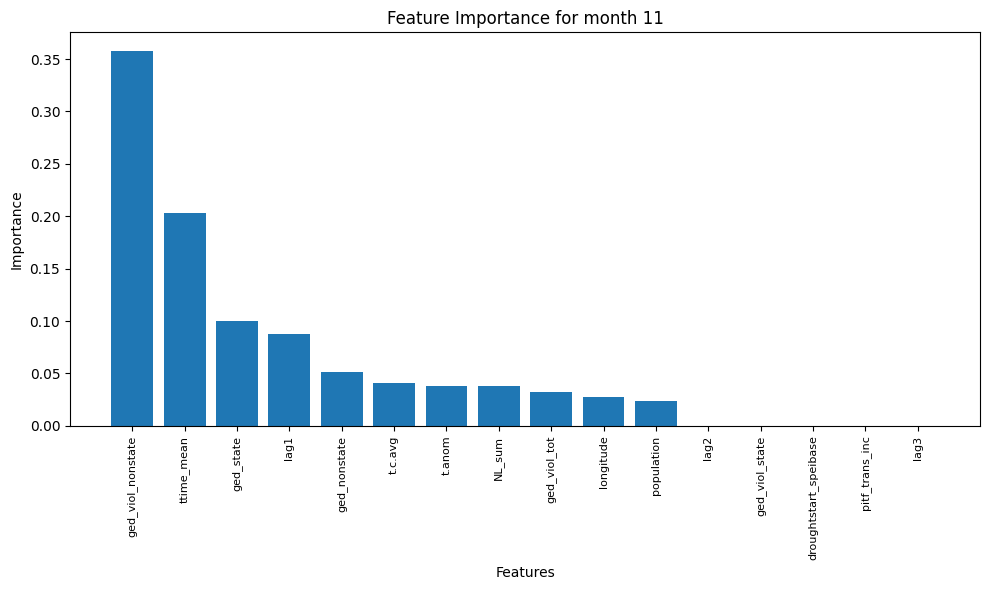

Month: 12
Mean Squared Error: 0.3004711540505944
R-squared: 0.9227280442578623


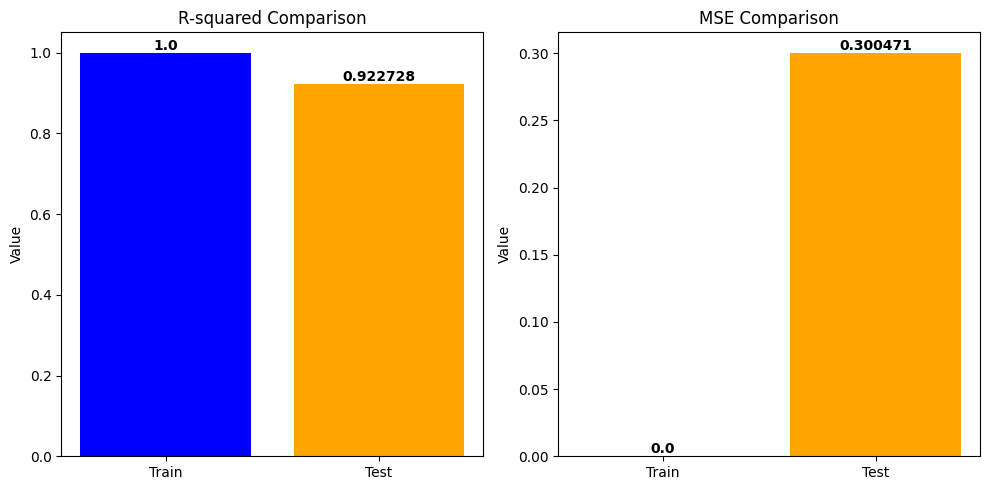

Feature Importance for month 12:
ged_viol_nonstate : 0.42046377
lag1 : 0.20462959
longitude : 0.11357922
ged_viol_tot : 0.090354316
population : 0.07832571
ged_state : 0.038292732
ttime_mean : 0.025032785
ged_nonstate : 0.0067566247
t.c.avg : 0.0066095325
pitf_multiple_camp : 0.005867232
t.anom : 0.0026256081
NL_sum : 0.0024830513
ged_viol_state : 0.002129471
acled_riots : 0.0020372025
nearest_country_dist : 0.000782096
droughtstart_speibase : 2.3015164e-05
mountains_mean : 7.646278e-06
acled_protests : 1.249306e-07
lag3 : 6.818974e-08
lag2 : 6.814088e-08
pitf_nonstate_inc : 5.780266e-08
month : 0.0
pitf_state_inc : 0.0
pitf_state_camp : 0.0
pitf_nonstate_sanc_inc : 0.0
pitf_nonstate_sanc_camp : 0.0
pitf_nonstate_camp : 0.0
pitf_multiple_inc : 0.0
pitf_trans_inc : 0.0
pitf_trans_camp : 0.0
desert.year : 0.0
desert.month_mean : 0.0
desert.count_mean : 0.0
partial.desert.sahara_mean : 0.0
own_borders_dist : 0.0


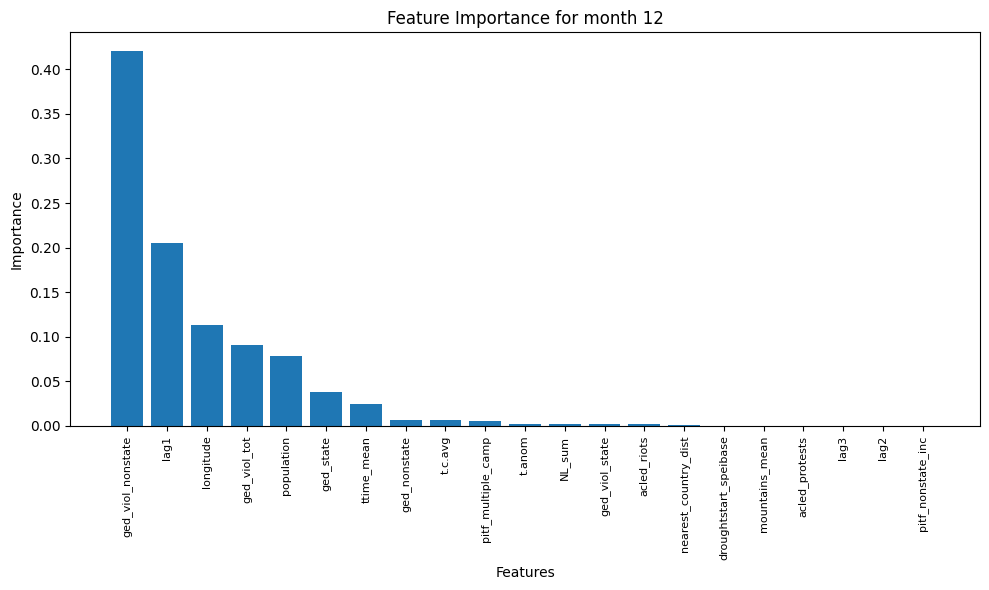

In [24]:
#We adjust the process for each of the 12 months present in the dataset

scaler = StandardScaler()
boosted = XGBRegressor(objective='reg:squarederror')
steps = [("transformer", data_preparation(X)), ("scaler", scaler), ("model", boosted)]
pipe = Pipeline(steps)

for month in df['month'].unique():

    df_month = df[df['month'] == month]
    X = df_month.drop('target', axis=1) 
    y = df_month['target']

    # We split the data (replace with your own splitting method)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    mse_boosted_1 = mean_squared_error(y_test, y_pred)
    r2_boosted_1 = r2_score(y_test, y_pred)

    print(f"Month: {month}")
    print("Mean Squared Error:", mse_boosted)
    print("R-squared:", r2_boosted_1)

    y_train_pred = pipe.predict(X_train)

    # We calculate the metrics for both train and test sets
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_pred)

    # We create bar plots for R-squared and MSE side by side
    #R-squared
    metrics = ['Train', 'Test']
    train_values = [r2_train, mse_train]
    test_values = [r2_test, mse_test]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.bar(metrics, [train_values[0], test_values[0]], color=['blue', 'orange'])
    ax1.set_ylabel('Value')
    ax1.set_title('R-squared Comparison')
    for i, v in enumerate([train_values[0], test_values[0]]):
        ax1.text(i, v, str(round(v, 6)), ha='center', va='bottom', fontweight='bold')

    # MSE
    ax2.bar(metrics, [train_values[1], test_values[1]], color=['blue', 'orange'])
    ax2.set_ylabel('Value')
    ax2.set_title('MSE Comparison')
    for i, v in enumerate([train_values[1], test_values[1]]):
        ax2.text(i, v, str(round(v, 6)), ha='center', va='bottom', fontweight='bold')

    # Adjusting spacing between subplots...
    plt.tight_layout()
    plt.show()
    plt.show()

    # And feature importance display and plots
    importance = pipe.named_steps['model'].feature_importances_
    feature_importance_dict = dict(zip(X.columns, importance))
    sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
    print(f"Feature Importance for month {month}:")
    for feature, importance in sorted_feature_importance:
        print(feature, ":", importance)

    # We filter out variables with importance equal to 0
    filtered_feature_importance = [(feature, importance) for feature, importance in sorted_feature_importance if importance != 0]
    features = [item[0] for item in filtered_feature_importance]
    importances = [item[1] for item in filtered_feature_importance]

    # We plot
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.bar(range(len(features)), importances)
    plt.xticks(range(len(features)), features, rotation=90, fontsize=8)  
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(f'Feature Importance for month {month}')
    plt.tight_layout()  # Adjust for the spacing of the plot elements
    plt.show()

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Third model: Deep Neural Network

Finally, we tried a Keras-built Sequential Neural Network, using three hidden layers of 64, 64 and 32 neurons (respectively), with a rectified linear unit as activation function. 

As we did, we checked for overfitting, and checked also for feature importance following the structure done in the other two models. In this case,  we have to one-hot encode all variables of type object beforehand, as keras does not allow for a full-fledged ```Pipeline```! Nonetheless, as we do not have objects anymore, we can proceed with the variables as they are!

In [25]:
df.dtypes.value_counts()

float64    26
int64      10
dtype: int64

In [26]:
#We create a variable to help us with the input shape: this will allow for automation depending on varying
#feature importances in the first block of the notebook cascading down. We basically display the columns after
#the previous transformation.

input_shape_help=df.shape[1]
input_shape_help

36

In [27]:
#train-test split

X=df.drop("target", axis=1)
y=df["target"]

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [28]:
# We then import all subsequent Keras modules we will need

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import History
from keras.utils import to_categorical
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
import tensorflow.keras.backend as K

In [29]:
# And create a function that returns the Keras model, with all parameters mentioned before inside.

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - SS_res/(SS_tot + K.epsilon())

def create_model(neurons1=64, neurons2=64, neurons3=32):
    model = Sequential()
    model.add(Dense(neurons1, input_shape=(input_shape_help-1,), activation='relu')) 
    model.add(Dense(neurons2, activation='relu'))
    model.add(Dense(neurons3, activation="relu"))
    model.add(Dense(1))  # Output layer with a single neuron for numerical target
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[MeanSquaredError(), MeanAbsoluteError(), 
                                                                        r_squared])
    model.summary()
    return model

In [30]:
# We create the pipeline with the Keras model embedded

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler(with_mean=False)),
    ('keras', KerasRegressor(build_fn=create_model, epochs=100, batch_size=64, verbose=0))
])

# We fit the pipeline with the training data
pipe.fit(X_train, y_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2304      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 8,577
Trainable params: 8,577
Non-trainable params: 0
_________________________________________________________________


Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler(with_mean=False)),
                ('keras',
                 <keras.wrappers.scikit_learn.KerasRegressor object at 0x7f8c68db9f10>)])

In [31]:
# We predict and display metrics
y_pred = pipe.predict(X_test)

mse_neural = mean_squared_error(y_test, y_pred)
r_squared_neural = r2_score(y_test, y_pred)
print("Mean Squared Error (MSE):", mse_neural)
print("R-squared (R^2):", r_squared_neural)

Mean Squared Error (MSE): 0.9239810969668445
R-squared (R^2): 0.9326319186675075


### Checking for overfitting

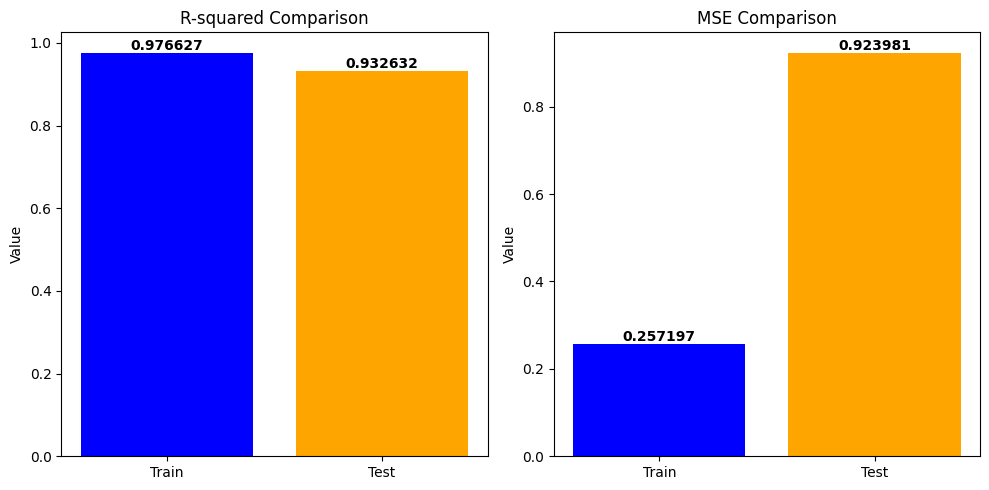

In [32]:
# We calculate metrics for both train and ttest
mse_neural = mean_squared_error(y_test, y_pred)
r_squared_neural = r2_score(y_test, y_pred)
y_train_pred = pipe.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_pred)

# We create bar plots for R-squared and MSE
#R-squared
metrics = ['Train', 'Test']  # Updated labels for columns
train_values = [r2_train, mse_train]
test_values = [r2_test, mse_test]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.bar(metrics, [train_values[0], test_values[0]], color=['blue', 'orange'])
ax1.set_ylabel('Value')
ax1.set_title('R-squared Comparison')
for i, v in enumerate([train_values[0], test_values[0]]):
    ax1.text(i, v, str(round(v, 6)), ha='center', va='bottom', fontweight='bold')

# MSE
ax2.bar(metrics, [train_values[1], test_values[1]], color=['blue', 'orange'])
ax2.set_ylabel('Value')
ax2.set_title('MSE Comparison')
for i, v in enumerate([train_values[1], test_values[1]]):
    ax2.text(i, v, str(round(v, 6)), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Ordered Feature Importance:
t.anom : 54.126488
NL_sum : 46.03128
month : 43.371136
population : 38.352936
lag1 : 36.94232
ttime_mean : 34.57797
mountains_mean : 31.76943
own_borders_dist : 30.930344
nearest_country_dist : 29.247072
lag2 : 27.16243
ged_state : 24.626251
droughtstart_speibase : 23.687881
acled_riots : 23.408268
longitude : 23.308271
ged_viol_nonstate : 22.599838
ged_viol_tot : 22.584648
pitf_nonstate_inc : 22.103182
t.c.avg : 18.797073
ged_nonstate : 16.721928
ged_viol_state : 15.207817
lag3 : 15.126923
acled_protests : 15.054571
pitf_multiple_camp : 10.271797
pitf_nonstate_sanc_camp : 8.668461
desert.month_mean : 8.133265
partial.desert.sahara_mean : 8.07168
pitf_nonstate_sanc_inc : 7.6626596
pitf_nonstate_camp : 7.502884
desert.count_mean : 7.4529324
pitf_state_camp : 7.2912602
pitf_multiple_inc : 7.247885
desert.year : 7.184057
pitf_state_inc : 7.1767592
pitf_trans_inc : 6.986391
pitf_trans_camp : 6.9633923


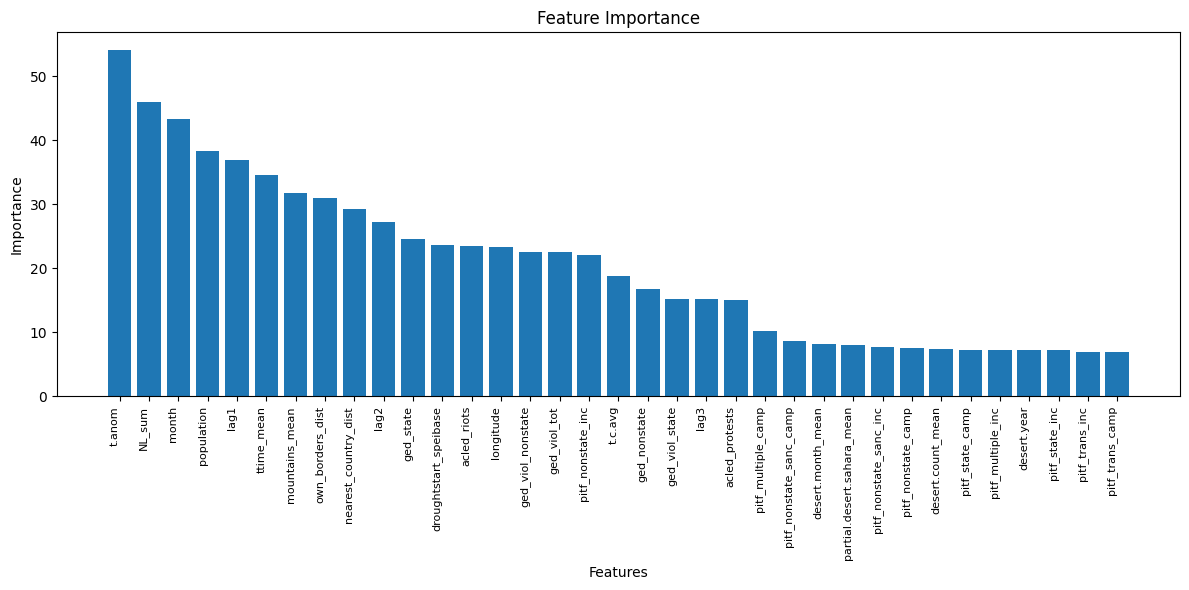

In [33]:
# We get the trained Keras model from the pipeline
keras_model = pipe.named_steps['keras'].model

# Then the weights of the first layer
weights_layer1 = keras_model.layers[0].get_weights()[0]

# We calculate the absolute sum of weights for each feature
feature_importances = np.abs(weights_layer1).sum(axis=1)

# We create a list of tuples containing feature name and importance
feature_importance_list = [(feature, importance) for feature, importance in zip(X_train.columns, feature_importances)]

# We sort the feature importance list in descending order
sorted_feature_importance = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

# We filter out variables with importance equal to 0
filtered_feature_importance = [(feature, importance) for feature, importance in sorted_feature_importance if importance != 0]

# We print the ordered list
print("Ordered Feature Importance:")
for feature, importance in filtered_feature_importance:
    print(feature, ":", importance)

# And plot it
features = [item[0] for item in filtered_feature_importance]
importances = [item[1] for item in filtered_feature_importance]
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.bar(range(len(features)), importances)
plt.xticks(range(len(features)), features, rotation=90, ha='right', fontsize=8)  # Rotate x-labels and adjust alignment
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()  # Adjust the spacing of the plot elements
plt.show()

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Final Models Results

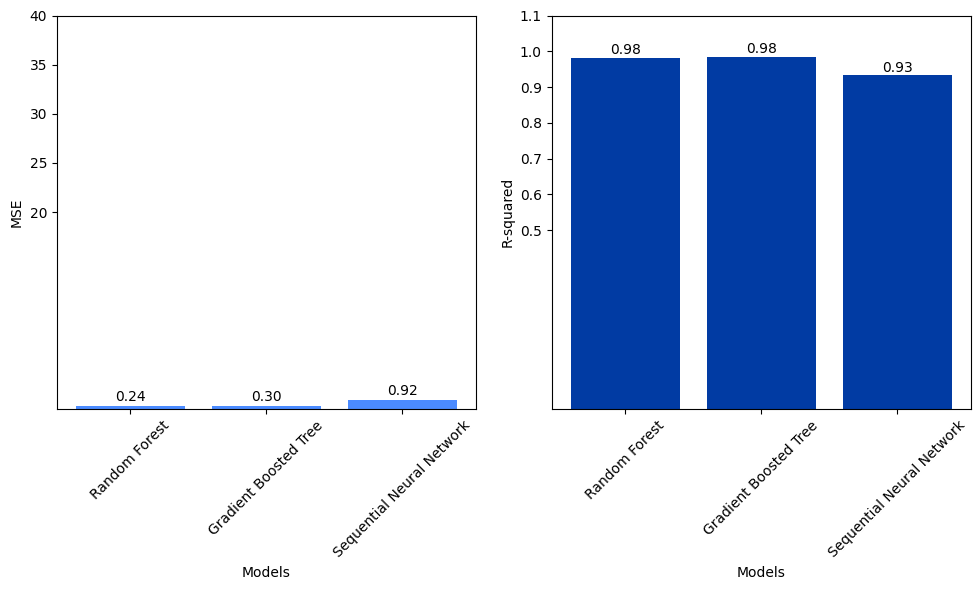

In [34]:
# We create a comprehensive Graph of MSE and R2

# We define the variables
models = ["Random Forest", "Gradient Boosted Tree", "Sequential Neural Network"]
mse_values = [mse_forest, mse_boosted, mse_neural]
r_squared_values = [r2_forest, r2_boosted, r_squared_neural]

#And plot
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)  # MSE subplot
plt.bar(models, mse_values, color='#4B8BFF')
plt.xlabel('Models')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.yticks(np.arange(20, 41, 5))
for i, mse in enumerate(mse_values):
    plt.text(i, mse + 0.5, f'{mse:.2f}', fontsize=10, ha='center')

# We then plot the R-squared values
plt.subplot(1, 2, 2)  # R-squared subplot
plt.bar(models, r_squared_values, color='#013BA3')
plt.xlabel('Models')
plt.ylabel('R-squared')
plt.xticks(rotation=45)
plt.yticks(np.arange(0.5, 1.1, 0.1))
for i, r_squared in enumerate(r_squared_values):
    plt.text(i, r_squared + 0.01, f'{r_squared:.2f}', fontsize=10, ha='center')

# We adjust the spacing between subplots and the layouts
plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

As we can see, our models are very good in terms of metrics, although when going to the monthly details, they may go a bit down in R-squared terms! Nonetheless, we are able to explain a huge amount of the conflicts fatalities variability. Next step should be replicating the approach for other countries datasets. In our case, no further data cleaning will be applied owing to the metrics obtained.